Các thư viện cần thiết, trong đó có `yfinance` để lấy data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install hypopt yfinance keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.regularizers import l1, l2
from keras.optimizers import Adam

from sklearn import tree
import xgboost as xgb
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler

from hypopt import GridSearch
import keras_tuner as kt

import yfinance as yf

from copy import deepcopy
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings("ignore")


# 1. Lấy Data

hàm lấy data, là cổ phiếu của 50 công ty trên sàn `EURO_STOXX_50` \
Kết quả trả về là 1 dataframe có dạng m dòng, 50 cột với m là time range

In [ ]:
def EU_Stock_data(start_time,end_time, time_range = 'max'):
    """Lấy dữ liệu giá Close của 50 công ty trên sàn Euro_STOXX 50 vào thời gian cho trước"""

    stock_list = pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]['Ticker'].to_list()
    # stock_list = ['AAPL', 'NVDA', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'AVGO', 'TSM', 'BRK.A', 'LLY', 'WMT',
    #               'JPM', 'V', 'MA', 'XOM', 'UNH', 'ORCL', 'COST', 'PG', 'HD', 'ACN', 'WFC', 'CSCO', 'NOW', 'AXP',
    #               'BX', 'MCD', 'IBM', 'AZN', 'PEP', 'TMO', 'AMD', 'MS', 'DIS', 'ABT', 'PFE', 'CVX', 'CRM', 'INTC',
    #               'CMCSA', 'LIN', 'NKE', 'T', 'MDT', 'UNP', 'HON', 'PM', 'KO', 'MRK']
    futures = pd.DataFrame()

    # xét từng mã
    for symbol in stock_list:
        try:
            df = yf.Ticker(symbol).history(period = time_range, start = start_time, end = end_time)
            df = pd.DataFrame(df['Close'])
            df.columns = [symbol]
            df.index = df.index.date
            futures = pd.concat([futures,df],axis = 1, join = 'outer').sort_index()
        except:
            continue

    futures['Date'] = pd.to_datetime(futures.index, format='%Y-%m-%d')
    futures.set_index('Date', inplace=True)

    return futures

# 2. Classic TSMOM

Hàm thực hiện tính toán để lấy về giá trị volatility (biến động) của mỗi ngày

In [ ]:
def Volatility_scale(data, ignore_na=False, adjust = True, com = 60, min_periods=0):
    """Scale data using ex ante volatility"""

    # Lưu trữ index, tức thời gian
    std_index = data.index

    # chứa kết quả
    daily_index = pd.DataFrame(index=std_index)

    # xét từng cổ phiếu
    for oo in data.columns:
        returns = data[oo]  # Lấy ra các return
        returns.dropna(inplace=True)  # xử lý null bằng zero

        returns = returns.rolling(2).apply(lambda x: x.iloc[1] / x.iloc[0] - 1)
        returns.iloc[0] =  0

        # Tính cumulative (cum) return , nhưng ko có thành phần - 1
        ret_index = (1 + returns).cumprod()

        # Tính daily volatility (vol)
        day_vol = returns.ewm(ignore_na=ignore_na,
                              adjust=adjust,
                              com=com,
                              min_periods=min_periods).std(bias=False)

        vol = day_vol * np.sqrt(252)  # scale lại theo 252 ngày active trading

        # Join cum return và vol
        ret_index = pd.concat([ret_index, vol], axis=1)
        ret_index.columns = [oo, oo + '_Vol']  # Đặt tên cột cum return là tên cổ phiếu, bên cạnh là vol

        # Join
        daily_index = pd.concat([daily_index, ret_index], join = 'outer' ,axis=1)

    return daily_index


In [ ]:
def classic_TSMOM(data, k, h, tolerance = 0,ignore_na = False, adjust = True, com = 60, min_periods = 0):

    signal = pd.DataFrame(index = data.index)

    company = data.columns

    # gọi hàm Volatility scale
    daily_index = Volatility_scale(data,ignore_na=ignore_na,
                          adjust=adjust,
                          com=com,
                          min_periods = min_periods)


    for oo in company:
        flag_h = 0
        flag_k = k+1
        df = pd.concat([daily_index[oo], daily_index[oo+"_Vol"]], axis=1)
        df = df.dropna(axis = 0, how = 'all')
        df['rolling returns'] = df[oo].pct_change(k) # so sánh thay đổi ở ngày t với k ngày trước đó (tức t - k)
        df['signal'] = 0.
        for x, v in enumerate(df['rolling returns']):
            if flag_h != 0:
                # Bỏ qua giai đoạn hold, tránh bị tính lặp lại
                flag_h = flag_h - 1
                continue
            # Bỏ qua thời gian cty chưa được lên sàn (nêu có)
            if df[oo].isnull().iloc[x] == False:
                # bỏ qua k ngày đầu vì chưa đủ k lookback
                if flag_k != 0:
                    flag_k = flag_k - 1
                    continue
            else: continue
            try:
                if df['rolling returns'].iloc[x-1] < tolerance:
                    for h_period in range(0,h):
                        # rolling return < 0, short rồi giữ trong h ngày, tính pnl, leverage///
                        df['signal'].iloc[x + h_period] = -1

                elif df['rolling returns'].iloc[x-1] > tolerance:
                    for h_period in range(0,h):
                        # rolling return > 0, long rồi giữ trong h ngày, tính pnl, leverage///
                        df['signal'].iloc[x + h_period] = 1

            except:pass


            # Đặt flag holding là h - 1, để qua vòng for mới bỏ qua ngày hold, tránh bị tính lặp lại
            if df['rolling returns'].iloc[x-1] != tolerance: flag_h = h - 1

        signal = pd.concat([signal, df['signal']], join = 'outer', axis=1)

    signal.columns = data.columns

    return signal

# 3. Model

## 3.1. Feature Engineering

In [ ]:
def MACD(data,period_fast,period_slow):
    EMA_fast = pd.Series(
        data.ewm(ignore_na=False, span=period_fast, adjust=True).mean()
    )
    EMA_Slow = pd.Series(
        data.ewm(ignore_na=False, span=period_slow, adjust=True).mean()
    )
    return EMA_fast - EMA_Slow

def MACD_normalized(data, period_fast, period_slow):
    macd = MACD(data, period_fast, period_slow)
    ewm_std = data.ewm(span = 63).std()
    q = macd / ewm_std
    z = q / q.ewm(span=252).std()
    return z

def calculate_rsi(data, period  = 14):
    # daily changes
    delta = data.diff()

    gain = (delta.where(delta > 0, 0))
    loss = (-delta.where(delta < 0, 0))

    # average gain and loss over the period
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

In [ ]:
def construct_features_single_asset(df, k, h, binary=True, test=False):
    """
    Constructs features and targets for either binary classification or regression.

    Args:
        df: DataFrame with Close prices
        k: Lookback period
        h: Holding period
        binary: If True, creates binary classification target using sign of future returns
               If False, creates regression target using scaled future returns
        test: If True, skips target creation for test data
    """
    df = df.dropna(how='any', axis=0)
    if df.shape[0] < 64:
        return None

    # Calculate returns and volatility
    # Method 1: Using rolling apply
    df["Return Daily"] = df["Close"].rolling(2).apply(lambda x: x.iloc[1] / x.iloc[0] - 1)
    df["Return Daily"].iloc[0] = 0
    df['next return daily'] = df['Return Daily'].shift(-1)
    df['next return daily'].iloc[-1] = 0 ## this.


    # Method 2: Using pct_change()
    # df["Return Daily"] = df["Close"].pct_change()

    df["volatility"] = Volatility_scale(pd.DataFrame(df["Close"]))["Close_Vol"]
    df['Cummulative Return'] = (1 + df['Return Daily']).cumprod(axis=0)

    # Calculate future returns r_{t, t+h}
    df['Next H Return'] = df['Cummulative Return'].pct_change(h).shift(-h)
    df['Mean H Return'] = df["Return Daily"].rolling(h+1).apply(lambda x: x.iloc[range(1,h+1)].mean()).shift(-h)
    df['Square Sum Return'] = df["Return Daily"].rolling(h+1).apply(lambda x: x.iloc[range(1,h+1)].pow(2).sum()).shift(-h)
    df['Next H Volatility'] = df["volatility"].shift(-h)

    # 1-day return: return from t-1 to t and # k-day return: return from t-k to t
    df["Past 1 Day"] = (df["Close"].pct_change(1)) / (df["volatility"] * np.sqrt(252))
    df[f"Past {k} Day"] = (df["Close"].pct_change(k)) / (df["volatility"] * np.sqrt(252))

    df["MACD_19_39"] = MACD_normalized(df["Close"], 19, 39)
    df["MACD_5_13"] = MACD_normalized(df["Close"], 5, 13)
    df['RSI_5'] = calculate_rsi(df['Close'], period=5)
    # df['RSI_10'] = calculate_rsi(df['Close'], period=10)
    df['Price_SMA_5'] = df['Close'] / df['Close'].rolling(5).mean() - 1

    # Create targets based on binary flag
    if not test:
        if binary:
            # Binary classification target
            df['output_binary'] = [1 if x > 0 else 0 for x in df['Next H Return']]
        else:
            # Regression target: r_{t+1, t+h} / σ_{t}
            df['output_reg'] = df['Next H Return'] / df['volatility']

    df = df.dropna(how='any',axis=0)

    # Handle lookback period
    temp = pd.DataFrame(columns=df.columns)
    n = 0
    while True:
        try:
            temp = pd.concat([temp, df.iloc[[n*h], :]], axis=0)
            n = n+1
        except:
            break
    try:
        df = temp[:-2]
    except:
        df = None

    return df

#### Examine vol, next h ...

In [ ]:
del data1
data1 = data[['ADYEN.AS']]
data1.columns = ['Close']
data1.head()

,Close
Date,
2018-12-31,475.049988
2019-01-02,470.899994
2019-01-03,463.049988
2019-01-04,500.000000
2019-01-07,531.200012


In [ ]:
x = data1.pct_change()[5 : 21]
x.columns = [['return']]
x

,return
Date,
2019-01-08,0.072854
2019-01-09,0.001228
2019-01-10,-0.032597
2019-01-11,-0.001812
2019-01-14,-0.007260
2019-01-15,0.029982
2019-01-16,0.018814
2019-01-17,0.024390
2019-01-18,0.051190


In [ ]:
a = 0.1 * (x.loc['2019-01-16'  : '2019-01-29', 'Close'].sum())
a ## mean next h return

0.015366526778014755

In [ ]:
b = (x.loc['2019-01-16'  : '2019-01-29', 'Close']**2).sum()
b ## square sum next  h

0.006450118844857924

In [ ]:
del df1
df1 = construct_features_single_asset(data1, k = 5,  h = 10)
df1

,Close,Return Daily,volatility,Cummulative Return,Next H Return,Mean H Return,Square Sum Return,Next H Volatility,output_binary,Past 1 Day,Past 5 Day,MACD_19_39,MACD_5_13,RSI_5,RSI_10,Price_SMA_5
2018-12-31,475.049988,0.000000,NaN,1.000000,0.185981,0.017919,0.017942,0.612393,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-15,563.400024,0.029982,0.612393,1.185981,0.162407,0.015367,0.006450,0.478990,1,0.003084,-0.001173,2.210245,1.548360,42.014732,77.687259,0.011853
2019-01-29,654.900024,0.019141,0.478990,1.378592,-0.006108,-0.000438,0.003496,0.435275,0,0.002517,0.002517,2.940890,2.030429,61.161549,84.065513,-0.001007
2019-02-12,650.900024,0.001385,0.435275,1.370172,0.033338,0.003345,0.001309,0.376336,1,0.000200,-0.000950,2.786731,0.532963,44.556986,47.826090,0.003237
2019-02-26,672.599976,0.001787,0.376336,1.415851,-0.072406,-0.007301,0.004221,0.375544,0,0.000299,-0.001137,3.211058,0.750616,42.123228,69.549506,0.002653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,1424.400024,0.004513,0.391146,2.998421,-0.017270,-0.001677,0.001312,0.367646,0,0.000727,0.006444,1.085438,0.747747,91.515189,63.916277,0.014299
2024-11-05,1399.800049,0.002866,0.367646,2.946637,-0.120874,-0.012592,0.005707,0.369589,0,0.000491,-0.006840,0.958575,-0.116992,6.042301,39.934550,-0.006445
2024-11-19,1230.599976,-0.006298,0.369589,2.590464,0.139119,0.013318,0.005992,0.371391,1,-0.001074,-0.005132,-0.673935,-1.934112,16.491236,16.051360,-0.016873
2024-12-03,1401.800049,-0.008207,0.371391,2.950847,0.072193,0.007059,0.001786,0.350149,1,-0.001392,0.002033,0.110278,1.550139,62.614047,83.753961,0.008286


#### Feature engineering 2 (added reg)

In [ ]:
def feature_engineering(data, k, h, supervised = False, binary = True):
    """
    Creates features for model training/testing

    Args:
        data: Price data
        k: Lookback period
        h: Holding period
        supervised: If True, creates supervised learning targets (binary/regression)
                   If False, creates targets for Sharpe optimization
        binary: If True, creates binary classification targets
                If False, creates regression targets
                Only used when supervised=True
    """
    company = data.columns
    features = ["Past 1 Day", f"Past {k} Day", "MACD_19_39", "MACD_5_13",
                "RSI_5",
                # "RSI_10",
                "Price_SMA_5"]

    X_train = pd.DataFrame(columns=features)

    if supervised:
        if binary:
            y_train = pd.DataFrame(columns=["output_binary"])
        else:
            y_train = pd.DataFrame(columns = ["output_reg"])
    else:
        # For Sharpe
        y_train = pd.DataFrame(columns=["Mean H Return","Square Sum Return","volatility", "Next H Return"])

    for oo in company:
        df = data[[oo]].copy()
        df.columns = ["Close"]

        # test=False since creating training data
        df = construct_features_single_asset(df, k, h, binary=binary, test=False)

        if df is None:
            continue

        X_train = pd.concat([X_train, df[features]], axis=0)

        if supervised:
            if binary:
                y_train = pd.concat([y_train, df[["output_binary"]]], axis=0)
            else:
                y_train = pd.concat([y_train, df[["output_reg"]]], axis=0)
        else:
            y_train = pd.concat([y_train, df[["Mean H Return","Square Sum Return","volatility","Next H Return"]]], axis=0)

    return [X_train, y_train]


## 3.2. Modeling

#### Tree - based

 Decision Tree

In [ ]:
def train_decision_tree(X_train,y_train,X_val,y_val,k,h):

    param_grid = {
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }


    model = GridSearch(model = tree.DecisionTreeClassifier(random_state=42), param_grid = param_grid,parallelize=False)
    model.fit(X_train, y_train, X_val, y_val)

    return model

 XGBoost

In [ ]:
def train_xgboost(X_train,y_train,X_val,y_val,k,h):

    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.001, 0.01, 0.1, 1.0],
        'n_estimators': [100, 200],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.6, 0.8, 1.0]
    }

    model = GridSearch(model = xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ), param_grid = param_grid,parallelize=False)

    model.fit(X_train, y_train, X_val, y_val)


    return model

In [ ]:
# def set_global_seeds(seed = 42):
#     """
#     Set all relevant random seeds for reproducibility.
#     This affects numpy, tensorflow, and Python's random module.
#     """
#     np.random.seed(seed)
#     tf.random.set_seed(seed)
#     random.seed(seed)

#     # Set session-level seeds for older TF versions
#     session_conf = tf.compat.v1.ConfigProto(
#         intra_op_parallelism_threads=1,
#         inter_op_parallelism_threads=1
#     )
#     sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#     tf.compat.v1.keras.backend.set_session(sess)

### MLP (supervised)

In [ ]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
class MLP_supervised(kt.HyperModel):
    def __init__(self, k, binary = True):
        self.k = k
        self.binary = binary

    def build(self,hp):


        model = Sequential([
            Dropout(0, input_shape = (6 ,)),
            Dense(units=hp.Choice(f"units", [5, 20, 40]),
                  activation = hp.Choice('activation', ['relu'])), # relu for positive only, elu for both.
            Dropout(rate = hp.Choice("dropout", [0.1, 0.3])),
             Dense(1, activation='sigmoid' if self.binary else None)
        ])


        model.compile(
            optimizer=Adam(
                learning_rate = hp.Choice("learning_rate", [1e-3, 1e-1, 1.0]),
                clipnorm = hp.Choice("max_grad_norm", [1e-2, 0.1, 1.0])
            ),
            loss = 'binary_crossentropy' if self.binary else  'mse',
        )
        return model

    def fit(self, hp, model, *args, **kwargs):

        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [256, 512]),
            **kwargs, epochs = 100, verbose = 1
        )


# class MLP_supervised(kt.HyperModel):
#     def __init__(self, k, seed=42):
#         self.k = k
#         self.seed = seed

#     def build(self, hp):
#         # Set seeds before model construction
#         tf.random.set_seed(self.seed)

#         model = Sequential([
#             Dropout(0, input_shape=(7,), seed=self.seed),
#             Dense(
#                 units=hp.Choice(f"units", [5, 10, 20, 40]),
#                 activation=hp.Choice('activation', ['tanh', 'elu']),
#                 kernel_initializer=tf.keras.initializers.GlorotUniform(seed=self.seed),
#                 bias_initializer='zeros'
#             ),
#             Dropout(
#                 rate=hp.Choice("dropout", [0.1, 0.3, 0.5]),
#                 seed=self.seed
#             ),
#             Dense(
#                 1,
#                 activation='sigmoid',
#                 kernel_initializer=tf.keras.initializers.GlorotUniform(seed=self.seed),
#                 bias_initializer='zeros'
#             ),
#         ])

#         optimizer = Adam(
#             learning_rate=hp.Choice("learning_rate", [1e-4, 1e-3, 1e-2, 1e-1, 1.0]),
#             clipnorm=hp.Choice("max_grad_norm", [1e-2, 0.1, 1.0, 10.0])
#         )

#         model.compile(
#             optimizer=optimizer,
#             loss="binary_crossentropy",
#         )
#         return model

#     def fit(self, hp, model, *args, **kwargs):
#         return model.fit(
#             *args,
#             batch_size=hp.Choice("batch_size", [256, 512, 1024]),
#             **kwargs,
#             epochs=80,
#             verbose=1,
#             shuffle=True,  # If True, use seeded shuffling
#         )


#### MLP training with hyper tuning

In [ ]:
def train_MLP_supervised(X_train, y_train, X_val, y_val, k, h, binary=True):
    """
    Train MLP model using grid search for either classification or regression.
    """
    tuner = kt.RandomSearch(
        MLP_supervised(k=k, binary = binary),
        objective="val_loss",
        max_trials = 100,
        directory="tuning_dir",
        project_name=f"tune_MLP_supervised_{'binary' if binary else 'reg'}"  # Different project names
    )

    es = EarlyStopping(monitor='val_loss', patience = 25, verbose = 1)

    # Different checkpoint paths based on binary flag
    checkpoint_filepath = (
        'Test/Data/checkpoint_mlp_sup_binary.model.keras' if binary
        else 'Test/Data/checkpoint_mlp_sup_reg.model.keras'
    )

    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    tuner.search(X_train, y_train,
                validation_data=(X_val, y_val),
                callbacks=[es])

    best_hp = tuner.get_best_hyperparameters()[0]
    model = tuner.hypermodel.build(best_hp)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        callbacks=[es, model_checkpoint],
        epochs=100,
        verbose=1
    )

    return model, history

#### train mlp sup reg  (no hyper tuning)

In [ ]:
# def train_MLP_supervised_2(X_train, y_train, X_val, y_val, k, h, binary=True): ## no hyper tune
#     """
#     Train MLP model using grid search for either classification or regression.

#     Args:
#         X_train: Training features
#         y_train: Training targets
#         X_val: Validation features
#         y_val: Validation targets
#         k: Lookback period
#         h: Holding period
#         binary: If True, trains classification model with binary cross-entropy loss
#                If False, trains regression model with MSE loss
#     """
#     tuner = kt.GridSearch(
#         MLP_supervised(k=k, binary = binary),  # Pass binary parameter to HyperModel
#         objective="val_loss",
#         max_trials=1,  # Only 1 trial needed for grid search
#         directory="tuning_dir",
#         project_name="tune_MLP_supervised"
#     )

#     es = EarlyStopping(monitor='val_loss', patience=25)
#     checkpoint_filepath = 'Test/Data/checkpoint_MLP_supervised.model.keras'
#     model_checkpoint = ModelCheckpoint(
#         filepath=checkpoint_filepath,
#         monitor='val_loss',
#         save_best_only=True
#     )

#     tuner.search(X_train, y_train,
#                 validation_data=(X_val, y_val),
#                 callbacks=[es])

#     best_hp = tuner.get_best_hyperparameters()[0]
#     model = tuner.hypermodel.build(best_hp)

#     history = model.fit(
#         X_train, y_train,
#         validation_data=(X_val, y_val),
#         callbacks=[model_checkpoint],
#         epochs=80,
#         verbose=1
#     )

#     return model, history

### Lasso (supervised)

In [ ]:
class Lasso_supervised(kt.HyperModel):
    def __init__(self, k, binary  = True):
        self.k = k
        self.binary = binary

    def build(self, hp):
        model = Sequential([
            Dense(1, input_shape = (6 ,),kernel_regularizer = l1(hp.Choice("l1_weight", [1e-4, 1e-3, 1e-1, 1.0])),
                  activation = 'sigmoid' if self.binary else None) # sigmoid for binary, else none
        ])

        model.compile(
            optimizer=Adam(
                learning_rate = hp.Choice("learning_rate", [1e-3, 1e-1, 1.0]),
                clipnorm = hp.Choice("max_grad_norm", [1e-2, 0.1, 1.0, 10.0])
            ),
            loss="binary_crossentropy" if self.binary else 'mse',
        )
        return model

    def fit(self, hp, model, *args, **kwargs):

        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [256, 512]),
            **kwargs, epochs = 100, verbose=1
        )


#### Lasso training with hyper tuning

In [ ]:
def train_Lasso_supervised(X_train, y_train, X_val, y_val, k, h, binary=True):
    """
    Train Lasso model using grid search for either classification or regression.
    """
    tuner = kt.RandomSearch(
        Lasso_supervised(k = k, binary=binary),
        objective="val_loss",
        max_trials = 100,
        directory="tuning_dir",
        project_name=f"tune_Lasso_supervised_{'binary' if binary else 'reg'}"  # Different project names
    )

    es = EarlyStopping(monitor='val_loss', patience=25, verbose=1)

    # Different checkpoint paths based on binary flag
    checkpoint_filepath = (
        'Test/Data/checkpoint_lasso_sup_binary.model.keras' if binary
        else 'Test/Data/checkpoint_lasso_sup_reg.model.keras'
    )

    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    tuner.search(X_train, y_train,
                validation_data=(X_val, y_val),
                callbacks=[es])

    best_hp = tuner.get_best_hyperparameters()[0]
    model = tuner.hypermodel.build(best_hp)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        callbacks=[es, model_checkpoint],
        epochs=80,
        verbose=1
    )

    return model, history

#### train with no hyper tuning

### Sharpe loss definition

In [ ]:
y_sharpeloss

,Mean H Return,Square Sum Return,volatility,Next H Return
2019-01-09,0.006753,0.000907,0.293103,0.069384
2019-01-23,-0.002401,0.003734,0.185821,-0.025567
2019-02-06,0.000094,0.000900,0.260282,0.000495
2019-02-20,0.007460,0.001439,0.229503,0.076695
2019-03-06,-0.003477,0.003458,0.212381,-0.035846
...,...,...,...,...
2024-09-18,-0.000313,0.005933,0.255239,-0.006098
2024-10-02,-0.002728,0.001441,0.279814,-0.027607
2024-10-16,-0.001672,0.002606,0.267367,-0.017876
2024-10-30,-0.009299,0.004810,0.266176,-0.091006


In [ ]:
def sharpe_loss(h,target_vol = 0.2):
    def calculation(y_target_dummy, y_pred):

        #mean = K.reshape(y_target_dummy[:, 0], (-1, 1))
        #square_sum =  K.reshape(y_target_dummy[:, 1], (-1, 1))
        next_h_ret = K.reshape(y_target_dummy[: -1], (-1, 1))
        volatility_scale = K.reshape(y_target_dummy[:, 2], (-1, 1))

        # sum_pofolio = K.mean(* h * y_pred * target_vol / volatility_scale
        ret  = next_h_ret * y_pred *  target_vol / volatility_scale
        mean_portfolio = K.mean(ret)

        std_portfolio = tf.math.sqrt(  K.sum((ret - mean_portfolio)**2)    / (tf.cast( tf.shape(next_h_ret)[0], tf.float32) - 1))

        # std_pofolio = tf.math.sqrt(K.mean(square_sum * y_pred **2  * (target_vol / volatility_scale)**2
        #                                   - 2 * sum_pofolio * mean_pofolio
        #                                   + (mean_pofolio ** 2) * h)/h)


        return  - (mean_portfolio / std_portfolio) *np.sqrt(252)
    return calculation

In [ ]:
def sharpe_loss_unsign(h, target_vol=0.2):
    def calculation(y_target_dummy, y_pred):

        y_pred = tf.cast(y_pred, tf.float32)
        next_return = tf.cast(y_target_dummy[:, 3], tf.float32)
        volatility = tf.cast(y_target_dummy[:, 2], tf.float32)

        next_return = tf.reshape(next_return, (-1, 1))
        volatility = tf.reshape(volatility, (-1, 1))

        ret = y_pred * target_vol/volatility * next_return
        mean_ret = tf.reduce_mean(ret)

        # Get batch size as tensor
        batch_size = tf.cast(tf.shape(ret)[0], tf.float32)

        var_ret = tf.reduce_sum(tf.square(ret - mean_ret)) / (batch_size - 1)

        # Add small epsilon to prevent division by zero
        # var_ret = var_ret + K.epsilon()

        # Return negative Sharpe ratio
        return -(mean_ret/tf.sqrt(var_ret)) * tf.sqrt(252.0)

    return calculation

### MLP (Sharpe Loss optimization)

In [ ]:
class MLP_SharpeLoss(kt.HyperModel):
    def __init__(self, k,h):
        self.k = k
        self.h = h

    def build(self,hp):
        model = Sequential([
            Dropout(0, input_shape=(6,)),
            Dense(units=hp.Choice(f"units", [5, 20]),activation = hp.Choice('activation', ['relu'])),
            Dropout(rate=hp.Choice("dropout", [0.1, 0.3, 0.5])),
            Dense(1,activation = 'tanh'),
        ])

        model.compile(
            optimizer=Adam(
                learning_rate=hp.Choice("learning_rate", [1e-4, 1e-3, 1e-2, 1e-1, 1.0]),
                clipnorm = hp.Choice("max_grad_norm", [1e-2, 0.1, 1.0])
            ),
            loss= sharpe_loss_unsign(h = self.h)
        )
        return model
    def fit(self, hp, model, *args, **kwargs):

        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [256,512]),
            **kwargs, epochs = 100, verbose=1
        )

In [ ]:
def train_MLP_sharpeLoss(X_train,y_train,X_val,y_val,k,h):

    tuner = kt.RandomSearch(
        MLP_SharpeLoss(k = k,h = h),
        objective="val_loss",
        max_trials = 100,
        overwrite=True,
        directory="tuning_dir",
        project_name="tune_MLP_sharpeLoss",
    )

    es = EarlyStopping(monitor='val_loss', verbose=1, patience=25)

    checkpoint_filepath = 'Test/Data/checkpoint_MLP_sharpeLoss.model.keras'
    model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor = 'val_loss',
    save_best_only=True)


    tuner.search(X_train, y_train, # epochs = 80,
                 callbacks = [es], validation_data = (X_val, y_val))

    hypermodel = MLP_SharpeLoss(k = k,h= h)
    best_hp = tuner.get_best_hyperparameters()[0]
    model = hypermodel.build(best_hp)

    history = hypermodel.fit(best_hp,model,X_train, y_train,callbacks = [model_checkpoint_callback],validation_data = (X_val, y_val))
    return model,history

### Lasso (Sharpe Loss optimization)

In [ ]:
class Lasso_SharpeLoss(kt.HyperModel):
    def __init__(self, k,h):
        self.k = k
        self.h = h

    def build(self,hp):
        model = Sequential([
            Dense(1, input_shape = (6, ), kernel_regularizer = l1(hp.Choice("l1_weight", [1e-3, 1e-2, 0.1,])),
                  activation='tanh')
        ])

        model.compile(
            optimizer=Adam(
                learning_rate=hp.Choice("learning_rate", [ 1e-3,  1e-1, 1.0]),
                clipnorm = hp.Choice("max_grad_norm", [1e-2, 0.1, 1.0])
            ),
            loss= sharpe_loss_unsign(h = self.h)
        )
        return model
    def fit(self, hp, model, *args, **kwargs):

        return model.fit(
            *args,
            # batch_size = 512,
            batch_size=hp.Choice("batch_size", [256, 512]),
            **kwargs, epochs = 120, verbose=1
        )


In [ ]:
def train_Lasso_sharpeLoss(X_train,y_train,X_val,y_val,k,h):

    tuner = kt.RandomSearch(
        Lasso_SharpeLoss(k = k,h = h),
        objective="val_loss",
        max_trials = 80,
        overwrite=True,
        directory="tuning_dir",
        project_name="tune_Lasso_sharpeLoss",
    )

    es = EarlyStopping(monitor='val_loss', verbose=1, patience=25)

    checkpoint_filepath = 'Test/Data/checkpoint_Lasso_sharpeLoss.model.keras'
    model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor = 'val_loss',
    save_best_only=True)


    tuner.search(X_train, y_train, callbacks = [es], validation_data=(X_val, y_val))

    hypermodel = Lasso_SharpeLoss(k = k,h= h)
    best_hp = tuner.get_best_hyperparameters()[0]
    model = hypermodel.build(best_hp)

    history = hypermodel.fit(best_hp,model,X_train, y_train,callbacks = [model_checkpoint_callback], validation_data = (X_val, y_val))
    return model,history

## 3.3. Test model

#### Test model 2

In [ ]:
def test_model_TSMOM_sign_sharpe(data, model, k, h):
    """
    Generate predictions for test data

    Args:
        data: Price data to test
        model: Trained model (classification/regression/Sharpe)
        k: Lookback period
        h: Holding period
    """
    company = data.columns

    # all_dates = data.index.unique()
    # # Sample every h-th date
    # sample_dates = all_dates[::h]
    # data = data.loc[sample_dates]

    signal = pd.DataFrame(index = data.index)

    features = ["Past 1 Day", f"Past {k} Day" , "MACD_19_39", "MACD_5_13",
                "RSI_5" ,
                # "RSI_10",
                "Price_SMA_5"]

    for oo in company:
        df = data[[oo]].copy()
        df.columns = ["Close"]

        # test=True since we're making predictions
        df = construct_features_single_asset(df, k, h, test=True)

        if df is None:
            continue

        time_index = data[oo].dropna(how='any').index
        company_signal = pd.DataFrame(index=time_index, columns=[oo])

        X_test = df[features]
        if X_test.shape[0] == 0:
            continue

        try:
            if model.loss == 'binary_crossentropy':  # Binary classification
                X_test['prediction'] = np.sign(model.predict(X_test) - 0.5)
            elif model.loss == 'mse':  # Regression
                X_test['prediction'] = np.sign(model.predict(X_test))
            else:  # Sharpe optimization đang xài sign
                X_test['prediction'] = np.sign(model.predict(X_test))
        except:  # Tree-based models
            X_test['prediction'] = model.predict(X_test) #  0 or 1
            X_test['prediction'][X_test['prediction'] == 0] = -1

        for x, v in enumerate(X_test.index):
            company_signal.loc[v, oo] = X_test.loc[v, 'prediction']


        company_signal = company_signal.ffill()
        company_signal = company_signal.fillna(0)
        signal = pd.concat([signal, company_signal], axis=1, join='outer')

    return signal

In [ ]:
def test_model_TSMOM_nosign_sharpe(data, model, k, h):
    """
    Generate predictions for test data

    Args:
        data: Price data to test
        model: Trained model (classification/regression/Sharpe)
        k: Lookback period
        h: Holding period
    """
    company = data.columns

    # all_dates = data.index.unique()
    # # Sample every h-th date
    # sample_dates = all_dates[::h]
    # data = data.loc[sample_dates]

    signal = pd.DataFrame(index = data.index)

    features = ["Past 1 Day", f"Past {k} Day" , "MACD_19_39", "MACD_5_13",
                "RSI_5" ,
                # "RSI_10",
                "Price_SMA_5"]

    for oo in company:
        df = data[[oo]].copy()
        df.columns = ["Close"]

        # test=True since we're making predictions
        df = construct_features_single_asset(df, k, h, test=True)

        if df is None:
            continue

        time_index = data[oo].dropna(how='any').index
        company_signal = pd.DataFrame(index=time_index, columns=[oo])

        X_test = df[features]
        if X_test.shape[0] == 0:
            continue

        try:
            if model.loss == 'binary_crossentropy':  # Binary classification
                X_test['prediction'] = np.sign(model.predict(X_test) - 0.5)
            elif model.loss == 'mse':  # Regression
                X_test['prediction'] = np.sign(model.predict(X_test))
            else:  # Sharpe optimization ko xài sign
                X_test['prediction'] = (model.predict(X_test))
        except:  # Tree-based models
            X_test['prediction'] = model.predict(X_test) #  0 or 1
            X_test['prediction'][X_test['prediction'] == 0] = -1

        for x, v in enumerate(X_test.index):
            company_signal.loc[v, oo] = X_test.loc[v, 'prediction']


        company_signal = company_signal.ffill()
        company_signal = company_signal.fillna(0)
        signal = pd.concat([signal, company_signal], axis=1, join='outer')

    return signal

#### curve


In [ ]:
# def loss_history(history, model_name):
#     fig, ax = plt.subplots(figsize=(12, 12))
#     ax.plot(history.history['loss'])
#     ax.plot(history.history['val_loss'])
#     ax.set_title(str(model_name) + ' loss')
#     ax.set_ylabel('loss')
#     ax.set_xlabel('epoch')
#     ax.legend(['train', 'validation'], loc='upper left')
#     fig.savefig(str(model_name) + ' loss.png')
#     del fig
#     del ax
#     return
def loss_history(history, model_name, skip_epochs=0, use_log_scale=True, figsize=(12, 6)):
    """Plot training and validation loss history with improved visualization."""
    train_loss = history.history['loss'][skip_epochs:]
    val_loss = history.history['val_loss'][skip_epochs:]
    epochs = range(skip_epochs+1, len(history.history['loss'])+1)

    fig, ax = plt.subplots(figsize=figsize)

    # Plot both training and validation loss
    ax.plot(epochs, train_loss, 'b-', linewidth=2, label='Training Loss')
    ax.plot(epochs, val_loss, 'r-', linewidth=2, label='Validation Loss')

    # Style the plot
    ax.set_title(f'{model_name} Loss Over Time (Epochs {skip_epochs+1} onwards)',
                 fontsize=14, pad=15)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)

    if use_log_scale:
        ax.set_yscale('log')
        ax.set_ylabel('Loss (log scale)', fontsize=12)

        # Add minor gridlines for log scale
        ax.grid(True, which='major', linestyle='-', alpha=0.5)
      #  ax.grid(True, which='minor', linestyle=':', alpha=0.2)
    else:
        ax.grid(True, linestyle='--', alpha=0.7)

    ax.legend(fontsize=10, loc='upper right')

    plt.tight_layout()
    plt.savefig(f'{model_name}_loss.png', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

In [ ]:
!pwd

/content


In [ ]:
# !rm -rf ./tuning_dir/tune_Lasso_sharpeLoss
# # !rm -rf tune_MLP_sharpeLoss
# !rm -rf ./tuning_dir/tune_MLP_supervised_reg
# !rm -rf ./tuning_dir/tune_Lasso_supervised
# !rm -rf ./tuning_dir/tune_MLP_sharpeLoss


In [ ]:
!rm -rf ./tuning_dir/tune_Lasso_supervised_binary/
!rm -rf ./tuning_dir/tune_Lasso_supervised_reg/
!rm -rf ./tuning_dir/tune_MLP_supervised_binary/
!rm -rf ./tuning_dir/tune_MLP_supervised_reg/


In [ ]:
%cd /content/

/content


In [ ]:
!rm -rf /content/Test/Data/checkpoint_lasso_sup_reg.model.keras
!rm -rf /content/Test/Data/checkpoint_mlp_sup_reg.model.keras

In [ ]:
!rm -rf /content/Test/Data/checkpoint_MLP_sharpeLoss.model.keras

In [ ]:
# !rm -rf /content/tuning_dir/tune_Lasso_supervised_reg
!rm -rf /content/tuning_dir/tune_MLP_sharpeLoss

# 4. Backtest

In [ ]:
def backtest_direct(data, signal, k, h,
                    vol_flag = 1, target_vol = 0.2,
                    ignore_na = False, adjust = True,
                    com = 60, min_periods = 0):

    pnl = pd.DataFrame(index=data.index)
    leverage = pd.DataFrame(index = data.index)
    company = signal.columns

    # Get volatility scaling data
    daily_index = Volatility_scale(data, ignore_na=ignore_na,
                                 adjust=adjust,
                                 com=com,
                                 min_periods = min_periods)

    for oo in company:
        flag_h = 0  # Counter for holding period
        flag_k = k+1  # Counter for initial lookback period

        df = pd.concat([daily_index[oo], daily_index[oo+"_Vol"]], axis=1)
        df = df.dropna(axis = 0, how = 'all')
        company_signal = signal[oo].dropna(axis = 0, how = 'all')

        df['pnl'] = 0.
        df['leverage'] = 0.

        for x, v in enumerate(df['pnl']):
            if flag_h != 0:
                # Skip days during holding period
                flag_h = flag_h - 1
                continue

            # Skip if data is missing or still in lookback period
            if df[oo].isnull().iloc[x] == False:
                if flag_k != 0:
                    flag_k = flag_k - 1
                    continue
            else:
                continue

            try:
                # Calculate PnL for next h days using signal from day x
                current_signal = company_signal.iloc[x]

                for h_period in range(0, h):
                    if vol_flag == 1:
                        df['pnl'].iloc[x + h_period] = (
                            df[oo].iloc[x + h_period] /
                            df[oo].iloc[x - 1 + h_period] - 1
                        ) * current_signal * target_vol / df[oo+"_Vol"].iloc[x - 1]

                        df['leverage'].iloc[x + h_period] = (
                            abs(current_signal) * target_vol /
                            df[oo+"_Vol"].iloc[x - 1]
                        )
                    else:
                        df['pnl'].iloc[x + h_period] = (
                            df[oo].iloc[x + h_period] /
                            df[oo].iloc[x - 1 + h_period] - 1
                        ) * current_signal

                        df['leverage'].iloc[x + h_period] = abs(current_signal)

                # Set holding period counter after calculating h days of PnL
                flag_h = h - 1

            except:
                pass

        leverage = pd.concat([leverage, df['leverage']], join='outer', axis=1)
        pnl = pd.concat([pnl, df['pnl']], join='outer', axis=1)

    pnl.columns = signal.columns
    leverage.columns = signal.columns

    return [pnl, leverage]

In [ ]:
def backtest(data,signal,k,h,  vol_flag = 1, target_vol = 0.2, ignore_na = False, adjust = True, com = 60, min_periods = 0):

    pnl = pd.DataFrame(index=data.index)
    leverage = pd.DataFrame(index = data.index)

    company = signal.columns

    # gọi hàm Volatility scale
    daily_index = Volatility_scale(data,ignore_na=ignore_na,
                          adjust=adjust,
                          com=com,
                          min_periods = min_periods)


    # Volatility settings
    vol_flag = vol_flag    # Set flag to 1 for vol targeting
    if vol_flag == 1:
        target_vol = target_vol
    else:
        target_vol = 'no target vol'


    for oo in company:
        flag_h = 0
        flag_k = k+1
        df = pd.concat([daily_index[oo], daily_index[oo+"_Vol"]], axis=1)
        df = df.dropna(axis = 0, how = 'all')

        company_signal = signal[oo].dropna(axis = 0, how = 'all')
        df['pnl'] = 0.
        df['leverage'] = 0.
        for x, v in enumerate(df['pnl']):
            if flag_h != 0:
                # Bỏ qua giai đoạn hold, tránh bị tính lặp lại
                flag_h = flag_h - 1
                continue
            # Bỏ qua thời gian cty chưa được lên sàn (nêu có)
            if df[oo].isnull().iloc[x] == False:
                # bỏ qua k ngày đầu vì chưa đủ k lookback
                if flag_k != 0:
                    flag_k = flag_k - 1
                    continue
            else: continue
            try: ## signal = -0.3 = (-1) * 0.3 => (s/t - 1) * (-1) * 0.3 = 0.3 * (1 - s/t ) =>
            ## signal = 0.3 => 1 * 0.3 * (s/t - 1) = > lời

                if company_signal.iloc[x] == -1:
                    for h_period in range(0,h):
                        if vol_flag == 1:
                            df['pnl'].iloc[x + h_period] = (1 - df[oo].iloc[x + h_period] / df[oo].iloc[x - 1 + h_period]) * \
                                target_vol / df[oo+"_Vol"].iloc[x -1]  # 0.3
                            df['leverage'].iloc[x + h_period] = target_vol / df[oo+"_Vol"].iloc[x -1]
                        else:
                            df['pnl'].iloc[x + h_period] = (1 - df[oo].iloc[x + h_period] / df[oo].iloc[x - 1 + h_period])
                            df['leverage'].iloc[x+h_period] = 1
                elif company_signal.iloc[x] == 1:
                    for h_period in range(0,h):
                        if vol_flag == 1:
                            df['pnl'].iloc[x + h_period] = (df[oo].iloc[x + h_period] / df[oo].iloc[x - 1 + h_period] - 1) * \
                                    target_vol / df[oo+"_Vol"].iloc[x - 1]
                            df['leverage'].iloc[x+h_period] = target_vol / df[oo+"_Vol"].iloc[x -1]
                        else:
                            df['pnl'].iloc[x + h_period] = (df[oo].iloc[x + h_period] / df[oo].iloc[x - 1 + h_period] - 1)
                            df['leverage'].iloc[x+h_period] = 1
            except:pass

            if signal[oo].iloc[x] == 1 or signal[oo].iloc[x] == -1 : flag_h = h - 1 ##


        leverage = pd.concat([leverage, df['leverage']], join = 'outer',axis = 1)
        pnl = pd.concat([pnl, df['pnl']], join = 'outer',axis=1)

    pnl.columns = signal.columns
    leverage.columns = signal.columns

    return [pnl,leverage]

In [ ]:
def strategy_daily_return(pnl):

    return pnl.mean(axis=1)

# 5. Example Code

## 5.4. Model

#### Settings

In [ ]:
## settings
start_time = '2018-12-31'
end_time = '2024-12-31'

data = EU_Stock_data(start_time = start_time, end_time = end_time)
test_data = data[data.index > datetime(pd.to_datetime(start_time).year + 5,12,31)]

In [ ]:
k = 5
h = 10 #  now optimal on this time rang

In [ ]:
data.isnull().sum().sum() / (len(data) * len(data.columns))

0.008988326848249028

In [ ]:
## for result storage
# stats = pd.DataFrame(columns = data.index) ## on train
stats_test = pd.DataFrame(columns = test_data.index) ## on test data

#### Construct feature and label

In [ ]:
# del X_sharpeloss, y_sharpeloss, X_supervised_reg, y_supervised_reg, X_supervised_binary, y_supervised_binary

In [ ]:
# labeling for 2 approaches
# X_supervised, y_supervised = feature_engineering(data, k, h, supervised = True)
X_sharpeloss, y_sharpeloss = feature_engineering(data, k, h, supervised = False)

In [ ]:
# 1. First, create features and targets for training/validation
X_supervised_reg, y_supervised_reg = feature_engineering(data, k, h, supervised=True, binary=False)
X_supervised_binary, y_supervised_binary = feature_engineering(data, k, h, supervised=True, binary=True)
# binary=False tells it to create regression targets (r_{t+1,t+h}/σ_{t}) instead of binary classification targets

In [ ]:
# Supervised binary
X_train_binary = np.array(X_supervised_binary[X_supervised_binary.index <= datetime(pd.to_datetime(start_time).year + 4,12,31)], dtype=np.float64)
y_train_binary = np.array(y_supervised_binary[y_supervised_binary.index <= datetime(pd.to_datetime(start_time).year + 4,12,31)], dtype=np.float64)
X_val_binary = np.array(X_supervised_binary[(X_supervised_binary.index > datetime(pd.to_datetime(start_time).year + 4,12,31)) &
                             (X_supervised_binary.index <= datetime(pd.to_datetime(start_time).year + 5,12,31))], dtype=np.float64)
y_val_binary = np.array(y_supervised_binary[(y_supervised_binary.index > datetime(pd.to_datetime(start_time).year + 4,12,31)) &
                             (y_supervised_binary.index <= datetime(pd.to_datetime(start_time).year + 5,12,31))], dtype=np.float64)
## supervised reg
X_train_reg = np.array(X_supervised_reg[X_supervised_reg.index <= datetime(pd.to_datetime(start_time).year + 4,12,31)], dtype=np.float64)
y_train_reg = np.array(y_supervised_reg[y_supervised_reg.index <= datetime(pd.to_datetime(start_time).year + 4,12,31)], dtype=np.float64)
X_val_reg = np.array(X_supervised_reg[(X_supervised_reg.index > datetime(pd.to_datetime(start_time).year + 4,12,31)) &
                             (X_supervised_reg.index <= datetime(pd.to_datetime(start_time).year + 5,12,31))], dtype=np.float64)
y_val_reg = np.array(y_supervised_reg[(y_supervised_reg.index > datetime(pd.to_datetime(start_time).year + 4,12,31)) &
                             (y_supervised_reg.index <= datetime(pd.to_datetime(start_time).year + 5,12,31))], dtype=np.float64)

In [ ]:
# Sharpe loss data
X_train_sharpe = np.array(X_sharpeloss[X_sharpeloss.index <= datetime(pd.to_datetime(start_time).year + 4,12,31)], dtype=np.float64)
y_train_sharpe = np.array(y_sharpeloss[y_sharpeloss.index <= datetime(pd.to_datetime(start_time).year + 4,12,31)], dtype=np.float64)
X_val_sharpe = np.array(X_sharpeloss[(X_sharpeloss.index > datetime(pd.to_datetime(start_time).year + 4,12,31)) &
                                    (X_sharpeloss.index <= datetime(pd.to_datetime(start_time).year + 5,12,31))], dtype=np.float64)
y_val_sharpe = np.array(y_sharpeloss[(y_sharpeloss.index > datetime(pd.to_datetime(start_time).year + 4,12,31)) &
                                    (y_sharpeloss.index <= datetime(pd.to_datetime(start_time).year + 5,12,31))], dtype=np.float64)


#### check overlap between train and val

In [ ]:
pd.set_option('display.max_rows', 110)

In [ ]:
cutoff1 = pd.Timestamp(pd.to_datetime(start_time).year + 4, 12, 31)
cutoff2 = pd.Timestamp(pd.to_datetime(start_time).year + 5, 12, 31)

In [ ]:
X_sharpeloss_train = X_sharpeloss[X_sharpeloss.index <= cutoff1]
X_sharpeloss_val = X_sharpeloss[(X_sharpeloss.index > cutoff1) &
                                (X_sharpeloss.index <= cutoff2)]

In [ ]:
X_sharpeloss_train[ :102]

,Past 1 Day,Past 5 Day,MACD_19_39,MACD_5_13,RSI_5,Price_SMA_5
2019-01-09,-0.000498,0.011014,2.077393,1.958411,83.870971,0.017211
2019-01-23,0.002471,0.015744,3.182373,3.158738,97.916743,0.013097
2019-02-06,-0.000955,-0.004930,2.359261,-0.220033,39.119217,0.001885
2019-02-20,0.000408,0.004767,0.637120,0.176396,71.698589,0.011917
2019-03-06,0.001232,0.006263,3.821368,1.896789,97.872587,0.007781
...,...,...,...,...,...,...
2022-11-02,-0.003251,-0.007728,-2.129935,-1.020131,0.194513,-0.018480
2022-11-16,-0.001920,0.004484,-0.403936,1.554758,64.965954,-0.013296
2022-11-30,0.001230,-0.001849,-0.020994,-0.109923,39.148979,-0.006178
2022-12-14,-0.000019,0.006447,-0.110254,0.057855,84.516194,0.029871


In [ ]:
X_sharpeloss_val[: (102 // 4)]

,Past 1 Day,Past 5 Day,MACD_19_39,MACD_5_13,RSI_5,Price_SMA_5
2023-01-12,0.001658,0.007191,1.486058,1.870573,85.843854,0.026324
2023-01-26,-0.000202,0.001056,1.554558,0.463318,57.037085,-0.011297
2023-02-09,0.001991,-0.001426,1.449897,0.820415,44.195782,0.001975
2023-02-23,-0.000593,-0.005151,0.403822,-0.919533,22.623655,-0.006965
2023-03-09,0.004035,0.008458,0.451672,1.027340,83.713792,0.031125
2023-03-23,0.001318,0.000363,0.146673,-0.462467,53.358376,0.004093
2023-04-06,-0.000176,0.008176,1.277385,2.411367,97.826189,0.002056
2023-04-24,-0.002011,-0.001153,1.373410,0.405532,39.298339,-0.006135
2023-05-09,-0.003691,0.005882,1.126105,0.823656,64.564074,0.010848
2023-05-23,-0.002813,-0.002719,0.833119,-0.342207,39.769494,-0.013868


#### test phase

In [ ]:
def prepare_test_features(test_data, k):
    """
    Prepare features for test data without labels.

    Args:
        test_data: DataFrame containing price data from 2023-12-31 to 2024-12-31
        k: lookback period for feature calculation

    Returns:
        DataFrame containing only the feature columns for predictions
    """
    company = test_data.columns
    features = ["Past 1 Day", f"Past {k} Day" , "MACD_19_39", "MACD_5_13",
                "RSI_5" ,
                # "RSI_10",
                "Price_SMA_5"]


    # for i in range(k,0,-1):
    #     features.append("Before " + str(i) + " Day")

    X_test = pd.DataFrame(columns=features)

    for oo in company:
        df = test_data[[oo]].copy()
        df.columns = ["Close"]

        # Use existing feature construction but skip label creation
        df = construct_features_single_asset(df, k, h, test=True)

        if df is not None:
            # Only keep the feature columns
            X_test = pd.concat([X_test, df[features]], axis=0)

    return X_test


In [ ]:
X_test = prepare_test_features(test_data, k)

In [ ]:
X_test

,Past 1 Day,Past 5 Day,MACD_19_39,MACD_5_13,RSI_5,Price_SMA_5
2024-01-09,0.001745,-0.005127,-2.534509,-0.646879,34.580897,0.010508
2024-01-23,0.001005,-0.007181,-2.757907,-1.834825,26.209689,0.008829
2024-02-06,0.000584,-0.004074,0.503835,0.638637,34.311892,0.006259
2024-02-20,0.001777,0.014070,1.667094,1.587614,93.833239,0.022053
2024-03-05,0.000795,-0.003976,2.147248,0.609470,29.921163,-0.008634
...,...,...,...,...,...,...
2024-09-06,-0.011659,-0.011180,-0.977848,-0.627797,25.414348,-0.040735
2024-09-20,-0.008225,-0.006459,-1.033576,-0.236265,31.468525,-0.018687
2024-10-04,0.005538,-0.012735,-0.705523,-0.193164,22.222230,0.003657
2024-10-18,0.003756,-0.002077,-0.845213,-0.522140,38.961054,0.004294


In [ ]:
def add_to_stats(stats, pnl, model_name):
    """Add model results to stats DataFrame

    Args:
        stats: DataFrame with dates as columns
        pnl: Series of returns over time
        model_name: String identifier for the model
    """
    if stats.empty:
        # Initialize DataFrame with dates as columns if empty
        stats = pd.DataFrame(columns=['Model'] + list(pnl.index))

    # Create new row with model name and pnl values
    new_row = [model_name] + pnl.tolist()
    stats.loc[len(stats.index)] = new_row

    return stats

#### run

In [ ]:
# 1. Classic TSMOM Strategy
signal = classic_TSMOM(test_data, k , h )
pnl = strategy_daily_return(backtest(test_data, signal, k, h)[0])

In [ ]:
stats_test = add_to_stats(stats_test, pnl, 'classic_tsmom_with target ( k = 5, h = 10)')

In [ ]:
# # 1. Classic TSMOM Strategy
# signal = classic_TSMOM(test_data, k , h ) # done
# pnl = strategy_daily_return(backtest(test_data, signal, k, h, vol_flag = None)[0]) #
# stats_test = add_to_stats(stats_test, pnl, 'classic_tsmom_no target ( k = 5, h = 10)')

In [ ]:
stats_test

,Model,2024-01-02 00:00:00,2024-01-03 00:00:00,2024-01-04 00:00:00,2024-01-05 00:00:00,2024-01-08 00:00:00,2024-01-09 00:00:00,2024-01-10 00:00:00,2024-01-11 00:00:00,2024-01-12 00:00:00,...,2024-12-13 00:00:00,2024-12-16 00:00:00,2024-12-17 00:00:00,2024-12-18 00:00:00,2024-12-19 00:00:00,2024-12-20 00:00:00,2024-12-23 00:00:00,2024-12-24 00:00:00,2024-12-27 00:00:00,2024-12-30 00:00:00
0,"classic_tsmom_with target ( k = 5, h = 10)",0.0,0.0,0.0,0.0,0.0,0.0,0.001201,0.001491,-0.001034,...,0.000996,-0.000713,-0.001773,-0.000582,0.00036,-0.001784,0.000202,-0.001647,0.001331,-0.000151


In [ ]:
# 2. Decision Tree
dt = train_decision_tree(X_train_binary, y_train_binary, X_val_binary, y_val_binary, k, h)
signal = test_model_TSMOM(test_data, dt, k, h)
pnl = strategy_daily_return(backtest(test_data, signal, k, h)[0])
stats_test = add_to_stats(stats_test, pnl, 'decision_tree ( k = 5, h = 10)')
del dt

In [ ]:
# 3. XGBoost
xgb = train_xgboost(X_train_binary, y_train_binary, X_val_binary, y_val_binary, k, h)
signal = test_model_TSMOM(test_data, xgb, k, h)
pnl = strategy_daily_return(backtest(test_data, signal, k, h)[0])
stats_test = add_to_stats(stats_test, pnl, 'xgboost ( k = 5, h = 10)')
del xgb

#### MLP reg

In [ ]:
mlp_sup_reg, history = train_MLP_supervised(X_train_reg, y_train_reg,
                                            X_val_reg, y_val_reg, k, h,
                                            binary = False)

signal = test_model_TSMOM(test_data, mlp_sup_reg, k, h)
pnl = strategy_daily_return(backtest(test_data, signal, k, h)[0])
stats_test = add_to_stats(stats_test, pnl, 'mlp_supervised_reg_tuned (k = 5, h = 3)')

Trial 100 Complete [00h 00m 19s]
val_loss: 0.011156363412737846

Best val_loss So Far: 0.011149656027555466
Total elapsed time: 00h 28m 38s
Epoch 1/100
522/529 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6160
Epoch 1: val_loss improved from inf to 0.01147, saving model to Test/Data/checkpoint_mlp_sup_reg.model.keras
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.5315 - val_loss: 0.0115
Epoch 2/100
497/529 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148
Epoch 2: val_loss improved from 0.01147 to 0.01125, saving model to Test/Data/checkpoint_mlp_sup_reg.model.keras
529/529 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0148 - val_loss: 0.0113
Epoch 3/100
522/529 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145
Epoch 3: val_loss improved from 0.01125 to 0.01120, saving model to Test/Data/checkpoint_mlp_sup_reg.model.keras
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0145 - val_loss: 0.0112
Epoch 4/100
517/529 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0142
Epoch 4: val_loss did not im

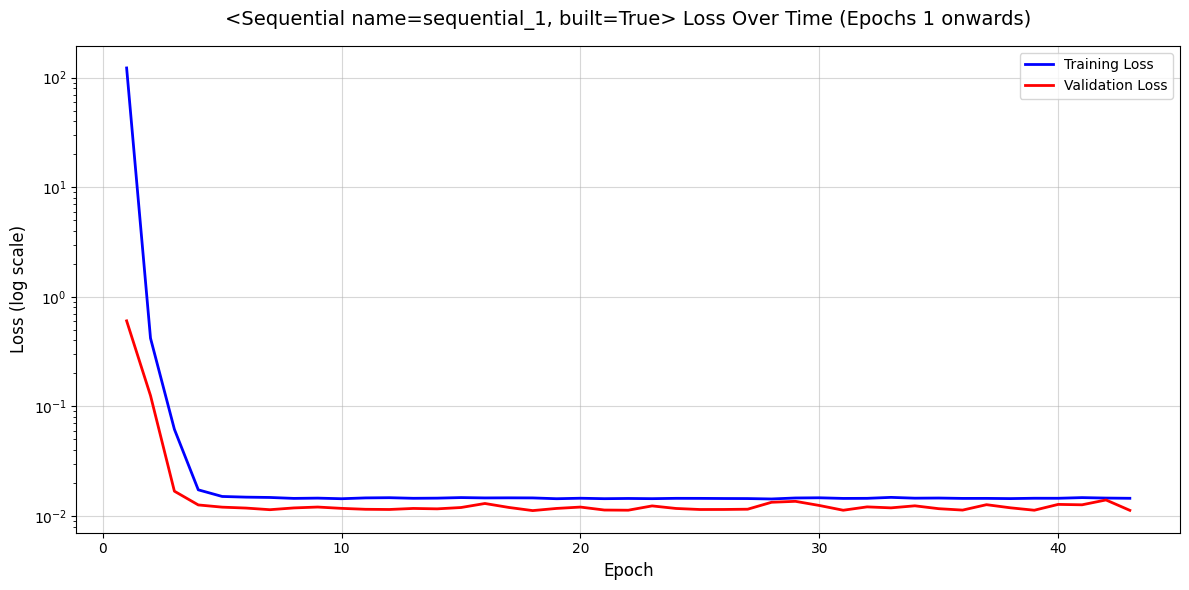

In [ ]:
loss_history(history, mlp_sup_reg, skip_epochs = 0, use_log_scale =  True)

In [ ]:
stats_test

,Model,2024-01-02 00:00:00,2024-01-03 00:00:00,2024-01-04 00:00:00,2024-01-05 00:00:00,2024-01-08 00:00:00,2024-01-09 00:00:00,2024-01-10 00:00:00,2024-01-11 00:00:00,2024-01-12 00:00:00,...,2024-12-13 00:00:00,2024-12-16 00:00:00,2024-12-17 00:00:00,2024-12-18 00:00:00,2024-12-19 00:00:00,2024-12-20 00:00:00,2024-12-23 00:00:00,2024-12-24 00:00:00,2024-12-27 00:00:00,2024-12-30 00:00:00
0,"classic_tsmom ( k = 5, h = 3)",0.0,0.0,0.0,0.0,0.0,0.0,0.001201,0.001491,-0.001034,...,-0.001737,-0.005727,-0.002193,-0.000420,0.000977,-0.000221,0.001203,0.000130,-0.005673,0.002680
1,"mlp_supervised_reg_tuned (k = 5, h = 3)",0.0,0.0,0.0,0.0,0.0,0.0,-0.001049,-0.007538,0.009881,...,0.001400,-0.004628,-0.004216,0.000033,-0.011214,-0.002927,-0.001911,0.000472,0.009311,-0.002538


#### MLP binary

In [ ]:
mlp_sup_binary, history = train_MLP_supervised(X_train_binary, y_train_binary,
                                                 X_val_binary, y_val_binary,
                                                 k, h, binary = True
                                                 )
signal = test_model_TSMOM(test_data, mlp_sup_binary, k, h)
pnl = strategy_daily_return(backtest(test_data, signal, k, h)[0])
stats_test = add_to_stats(stats_test, pnl, 'mlp_supervised_binary_tuned (k = 5, h = 10)')
# del mlp_sup_binary

Trial 10 Complete [00h 00m 09s]
val_loss: 0.6806921362876892

Best val_loss So Far: 0.6790739297866821
Total elapsed time: 00h 02m 41s
Epoch 1/80
138/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3120
Epoch 1: val_loss improved from inf to 0.69112, saving model to Test/Data/checkpoint_mlp_sup_binary.model.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.3050 - val_loss: 0.6911
Epoch 2/80
129/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0110
Epoch 2: val_loss did not improve from 0.69112
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0002 - val_loss: 0.6914
Epoch 3/80
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8064
Epoch 3: val_loss improved from 0.69112 to 0.68451, saving model to Test/Data/checkpoint_mlp_sup_binary.model.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8054 - val_loss: 0.6845
Epoch 4/80
140/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7080
Epoch 4: val_loss improved from 0.68451 to 0.68219, saving model to Test/Data/checkpoint_mlp_sup_

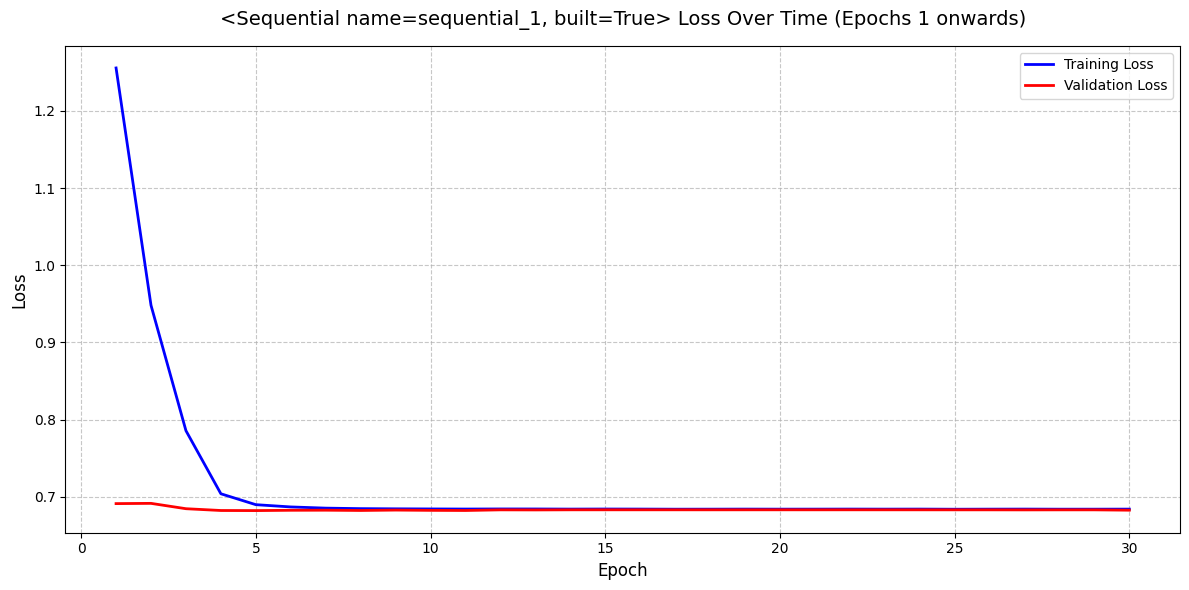

In [ ]:
loss_history(history, mlp_sup_binary, use_log_scale = False)

#### Lasso reg

In [ ]:
stats_test_rerun = stats_test.drop([2])

In [ ]:
stats_test_rerun

,Model,2024-01-02 00:00:00,2024-01-03 00:00:00,2024-01-04 00:00:00,2024-01-05 00:00:00,2024-01-08 00:00:00,2024-01-09 00:00:00,2024-01-10 00:00:00,2024-01-11 00:00:00,2024-01-12 00:00:00,...,2024-12-13 00:00:00,2024-12-16 00:00:00,2024-12-17 00:00:00,2024-12-18 00:00:00,2024-12-19 00:00:00,2024-12-20 00:00:00,2024-12-23 00:00:00,2024-12-24 00:00:00,2024-12-27 00:00:00,2024-12-30 00:00:00
0,"classic_tsmom ( k = 5, h = 3)",0.0,0.0,0.0,0.0,0.0,0.0,0.001201,0.001491,-0.001034,...,-0.001737,-0.005727,-0.002193,-0.000420,0.000977,-0.000221,0.001203,0.000130,-0.005673,0.002680
1,"mlp_supervised_reg_tuned (k = 5, h = 3)",0.0,0.0,0.0,0.0,0.0,0.0,-0.001049,-0.007538,0.009881,...,0.001400,-0.004628,-0.004216,0.000033,-0.011214,-0.002927,-0.001911,0.000472,0.009311,-0.002538


In [ ]:
!rm -rf /content/tuning_dir/tune_Lasso_supervised_reg
!rm -rf /content/Test/Data/checkpoint_lasso_sup_reg.model.keras

In [ ]:
lasso_sup_reg, history = train_Lasso_supervised(X_train_reg, y_train_reg,
                                            X_val_reg, y_val_reg, k, h,
                                            binary = False)
#
signal = test_model_TSMOM(test_data, lasso_sup_reg, k, h)
pnl = strategy_daily_return(backtest(test_data, signal, k, h)[0])
stats_test_rerun = add_to_stats(stats_test_rerun, pnl, 'lasso_supervised_reg_tuned (k = 5, h = 3)')
# del lasso_sup_reg

Trial 84 Complete [00h 00m 14s]
val_loss: 6.977940082550049

Best val_loss So Far: 0.011179783381521702
Total elapsed time: 00h 25m 13s
Epoch 1/80
512/529 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 270.6218
Epoch 1: val_loss improved from inf to 0.60340, saving model to Test/Data/checkpoint_lasso_sup_reg.model.keras
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 265.6526 - val_loss: 0.6034
Epoch 2/80
518/529 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6160
Epoch 2: val_loss improved from 0.60340 to 0.12551, saving model to Test/Data/checkpoint_lasso_sup_reg.model.keras
529/529 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6116 - val_loss: 0.1255
Epoch 3/80
491/529 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1051
Epoch 3: val_loss improved from 0.12551 to 0.01684, saving model to Test/Data/checkpoint_lasso_sup_reg.model.keras
529/529 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1021 - val_loss: 0.0168
Epoch 4/80
515/529 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0189
Epoch 4: val_loss improved

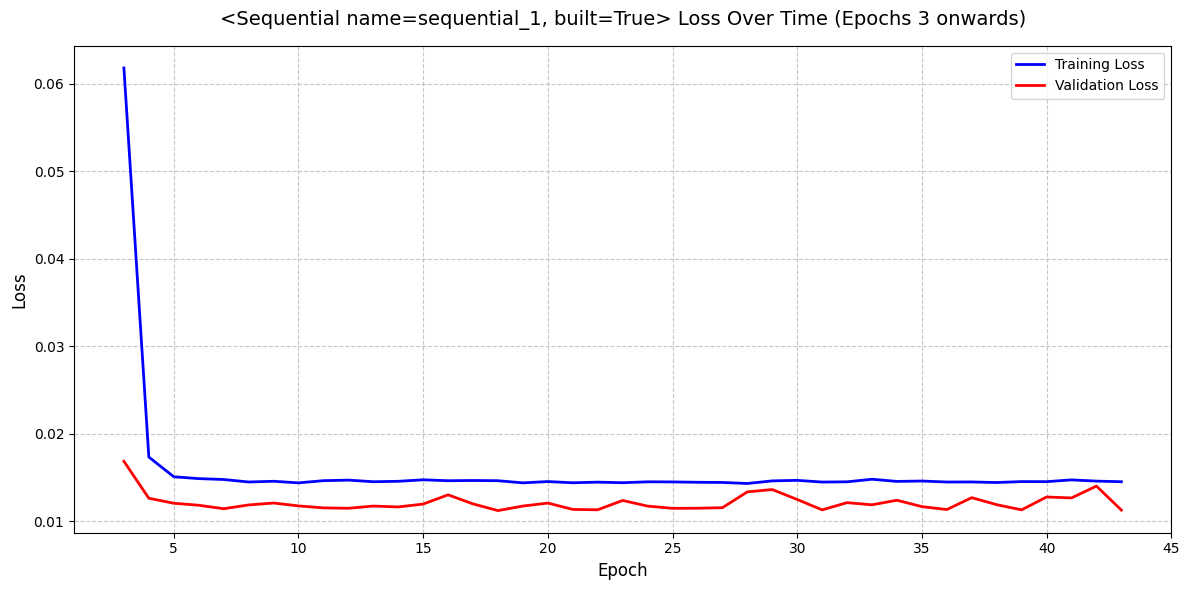

In [ ]:
loss_history(history, lasso_sup_reg, skip_epochs = 2, use_log_scale = False)

In [ ]:
stats_test_rerun

,Model,2024-01-02 00:00:00,2024-01-03 00:00:00,2024-01-04 00:00:00,2024-01-05 00:00:00,2024-01-08 00:00:00,2024-01-09 00:00:00,2024-01-10 00:00:00,2024-01-11 00:00:00,2024-01-12 00:00:00,...,2024-12-13 00:00:00,2024-12-16 00:00:00,2024-12-17 00:00:00,2024-12-18 00:00:00,2024-12-19 00:00:00,2024-12-20 00:00:00,2024-12-23 00:00:00,2024-12-24 00:00:00,2024-12-27 00:00:00,2024-12-30 00:00:00
0,"classic_tsmom ( k = 5, h = 3)",0.0,0.0,0.0,0.0,0.0,0.0,0.001201,0.001491,-0.001034,...,-0.001737,-0.005727,-0.002193,-0.000420,0.000977,-0.000221,0.001203,0.000130,-0.005673,0.002680
1,"mlp_supervised_reg_tuned (k = 5, h = 3)",0.0,0.0,0.0,0.0,0.0,0.0,-0.001049,-0.007538,0.009881,...,0.001400,-0.004628,-0.004216,0.000033,-0.011214,-0.002927,-0.001911,0.000472,0.009311,-0.002538
2,"lasso_supervised_reg_tuned (k = 5, h = 3)",0.0,0.0,0.0,0.0,0.0,0.0,-0.001049,-0.007538,0.009881,...,0.001400,-0.004628,-0.004216,0.000033,-0.011214,-0.002927,-0.001911,0.000472,0.009311,-0.002538


#### Lasso binary

In [ ]:
lasso_sup_binary, history = train_Lasso_supervised(X_train_binary, y_train_binary,
                                            X_val_binary, y_val_binary, k, h,
                                            binary = True)
#loss_history(history, lasso_sup_binary)

signal = test_model_TSMOM(test_data, lasso_sup_binary, k, h)
pnl = strategy_daily_return(backtest(test_data, signal, k, h)[0])
stats_test = add_to_stats(stats_test, pnl, 'lasso_supervised_binary_tuned (k = 5, h = 10)')
# del lasso_sup_binary

Trial 96 Complete [00h 00m 17s]
val_loss: 1.4710206985473633

Best val_loss So Far: 0.6805873513221741
Total elapsed time: 00h 22m 59s
Epoch 1/80
142/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1704
Epoch 1: val_loss improved from inf to 0.69986, saving model to Test/Data/checkpoint_lasso_sup_binary.model.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.9658 - val_loss: 0.6999
Epoch 2/80
138/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7635
Epoch 2: val_loss did not improve from 0.69986
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7690 - val_loss: 0.7246
Epoch 3/80
125/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7711
Epoch 3: val_loss did not improve from 0.69986
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7734 - val_loss: 0.8349
Epoch 4/80
154/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7484
Epoch 4: val_loss improved from 0.69986 to 0.69302, saving model to Test/Data/checkpoint_lasso_sup_binary.model.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - los

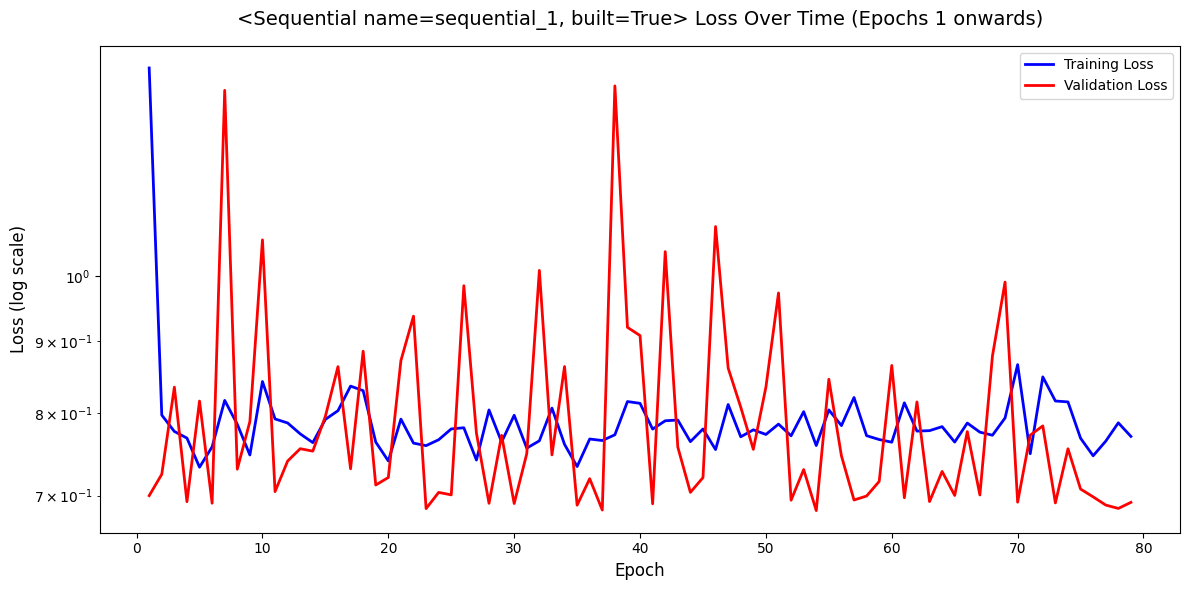

In [ ]:
loss_history(history, lasso_sup_binary)

In [ ]:
# stats_test.drop([3], inplace = True)

In [ ]:
stats_test

,Model,2024-01-02 00:00:00,2024-01-03 00:00:00,2024-01-04 00:00:00,2024-01-05 00:00:00,2024-01-08 00:00:00,2024-01-09 00:00:00,2024-01-10 00:00:00,2024-01-11 00:00:00,2024-01-12 00:00:00,...,2024-12-13 00:00:00,2024-12-16 00:00:00,2024-12-17 00:00:00,2024-12-18 00:00:00,2024-12-19 00:00:00,2024-12-20 00:00:00,2024-12-23 00:00:00,2024-12-24 00:00:00,2024-12-27 00:00:00,2024-12-30 00:00:00
0,"classic_tsmom ( k = 5, h = 10)",0.0,0.0,0.0,0.0,0.0,0.0,0.001201,0.001491,-0.001034,...,0.000996,-0.000713,-0.001773,-0.000582,0.000360,-0.001784,0.000202,-0.001647,0.001331,-0.000151
1,"decision_tree ( k = 5, h = 10)",0.0,0.0,0.0,0.0,0.0,0.0,0.000059,-0.003898,0.004133,...,0.000880,-0.002861,-0.001233,-0.000697,-0.005921,-0.001345,0.000015,0.000537,0.003783,-0.001691
2,"mlp_supervised_reg_tuned (k = 5, h = 10)",0.0,0.0,0.0,0.0,0.0,0.0,-0.001049,-0.007538,0.009881,...,0.001525,-0.004637,-0.004214,0.000022,-0.011173,-0.002928,-0.001890,0.000469,0.009156,-0.002443
3,"mlp_supervised_binary_tuned (k = 5, h = 10)",0.0,0.0,0.0,0.0,0.0,0.0,-0.001049,-0.007538,0.009881,...,0.001525,-0.004637,-0.004214,0.000022,-0.011173,-0.002928,-0.001890,0.000469,0.009156,-0.002443
4,"lasso_supervised_reg_tuned (k = 5, h = 10)",0.0,0.0,0.0,0.0,0.0,0.0,-0.001209,0.000800,-0.000715,...,-0.000462,-0.004625,-0.001118,-0.000736,-0.002768,0.000622,-0.000301,0.001147,0.004644,0.000112
5,"lasso_supervised_binary_tuned (k = 5, h = 10)",0.0,0.0,0.0,0.0,0.0,0.0,-0.000579,-0.006050,0.006199,...,0.001650,-0.004471,-0.003689,-0.000326,-0.010173,-0.002870,-0.001965,0.000351,0.008910,-0.002182


In [ ]:
# # 4. Supervised Learning Models (MLP and Lasso)
# for model_name in ['train_MLP_supervised', 'train_Lasso_supervised']:
#     model, history = globals()[model_name](X_train_sup, y_train_sup, X_val_sup, y_val_sup, k, h)
#     loss_history(history, model_name)

#     signal = test_model_TSMOM(test_data, model, k, h)
#     pnl = strategy_daily_return(backtest(test_data, signal, k, h)[0])
#     stats_test = add_to_stats(stats_test, pnl, model_name.replace('train_', ''))

#     del model, history

#### Sharpe MLP

In [ ]:
# 5. Sharpe Loss Optimization Models
# MLP with Sharpe Loss
mlp_sharpe, history_mlp = train_MLP_sharpeLoss(X_train_sharpe, y_train_sharpe,
                                           X_val_sharpe, y_val_sharpe,
                                           k, h)

Trial 100 Complete [00h 00m 08s]
val_loss: 1.8945890665054321

Best val_loss So Far: -2.3894855976104736
Total elapsed time: 00h 17m 30s
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: -0.9466 - val_loss: -1.9472
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: -1.2001 - val_loss: -1.9489
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: -0.8838 - val_loss: -1.9456
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: -1.3236 - val_loss: -1.9524
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -1.2720 - val_loss: -1.9522
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: -1.0284 - val_loss: -1.9526
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: -1.4264 - val_loss: -1.9527
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: -1.4091 - val_loss: -1.9527
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: -1.3933 - val_loss: -1.9527
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: -1.3444 - val_loss:

In [ ]:
# loss_history(history, 'MLP_SharpeLoss')
signal_mlp_sharpe = test_model_TSMOM_nosign_sharpe(test_data, mlp_sharpe, k, h)
pnl_mlp_sharpe = strategy_daily_return(backtest_direct(test_data, signal_mlp_sharpe, k, h)[0])
stats_test = add_to_stats(stats_test, pnl_mlp_sharpe, 'MLP SharpeLoss with direct (k = 5, h = 10)')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

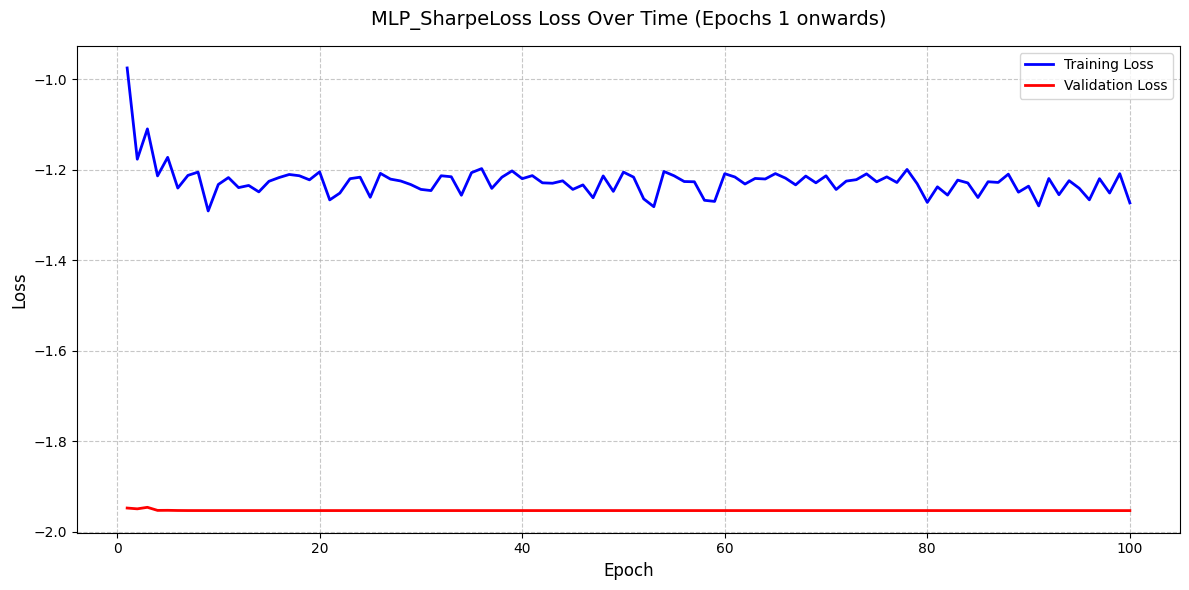

In [ ]:
loss_history(history_mlp, 'MLP_SharpeLoss', use_log_scale = False)

#### Sharpe Lasso

In [ ]:
# Lasso with Sharpe Loss
lasso_sharpe, history_lasso = train_Lasso_sharpeLoss(X_train_sharpe, y_train_sharpe,
                                               X_val_sharpe, y_val_sharpe, k, h)
#

# del lasso_sharpe, history

Trial 46 Complete [00h 00m 21s]
val_loss: 1.8291910886764526

Best val_loss So Far: -2.081850051879883
Total elapsed time: 00h 08m 26s
Epoch 1/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: -0.9747 - val_loss: -1.5655
Epoch 2/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -1.0200 - val_loss: -1.5762
Epoch 3/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.7756 - val_loss: -1.5887
Epoch 4/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -1.1415 - val_loss: -1.5996
Epoch 5/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -1.0138 - val_loss: -1.6101
Epoch 6/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -1.3842 - val_loss: -1.6195
Epoch 7/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -1.0021 - val_loss: -1.6295
Epoch 8/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.9519 - val_loss: -1.6383
Epoch 9/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.9996 - val_loss: -1.6486
Epoch 10/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -1.0862 - val_loss: -

In [ ]:
signal_lasso_sharpe = test_model_TSMOM_nosign_sharpe(test_data, lasso_sharpe, k, h)
pnl_lasso_sharpe = strategy_daily_return(backtest_direct(test_data, signal_lasso_sharpe, k, h)[0])
stats_test = add_to_stats(stats_test, pnl_lasso_sharpe, 'Lasso_SharpeLoss with direct (k = 5, h = 10)')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

In [ ]:
stats_test

,Model,2024-01-02 00:00:00,2024-01-03 00:00:00,2024-01-04 00:00:00,2024-01-05 00:00:00,2024-01-08 00:00:00,2024-01-09 00:00:00,2024-01-10 00:00:00,2024-01-11 00:00:00,2024-01-12 00:00:00,...,2024-12-13 00:00:00,2024-12-16 00:00:00,2024-12-17 00:00:00,2024-12-18 00:00:00,2024-12-19 00:00:00,2024-12-20 00:00:00,2024-12-23 00:00:00,2024-12-24 00:00:00,2024-12-27 00:00:00,2024-12-30 00:00:00
0,"classic_tsmom_with target ( k = 5, h = 10)",0.0,0.0,0.0,0.0,0.0,0.0,0.001201,0.001491,-0.001034,...,0.000996,-0.000713,-0.001773,-0.000582,0.000360,-0.001784,0.000202,-0.001647,0.001331,-0.000151
1,"MLP SharpeLoss with direct (k = 5, h = 10)",0.0,0.0,0.0,0.0,0.0,0.0,0.000073,0.006666,-0.009540,...,-0.001315,0.002585,0.004298,-0.000191,0.010769,0.003024,0.001273,-0.000482,-0.008351,0.002921
2,"Lasso_SharpeLoss with direct (k = 5, h = 10)",0.0,0.0,0.0,0.0,0.0,0.0,-0.000252,-0.004014,0.004948,...,0.000579,-0.000606,-0.001637,0.000256,-0.004222,-0.001456,-0.000505,-0.000132,0.003043,-0.000705


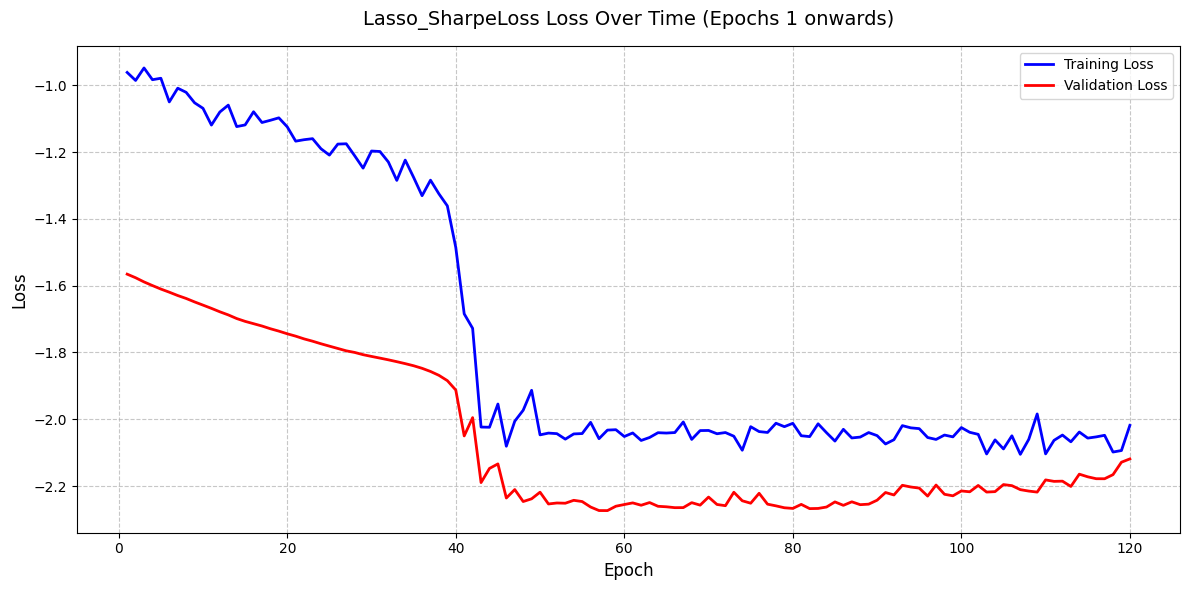

In [ ]:
loss_history(history_lasso, 'Lasso_SharpeLoss', use_log_scale= False)

## Debugging

In [ ]:
!pwd

/content


In [ ]:
%cd ./Test/Data

/content/Test/Data


In [ ]:
import tensorflow as tf

# Load the saved models
# mlp_supervised = tf.keras.models.load_model('checkpoint_MLP_supervised.model.keras')
# lasso_supervised = tf.keras.models.load_model('checkpoint_Lasso_supervised.model.keras')
# mlp_sharpe = tf.keras.models.load_model('checkpoint_MLP_sharpeLoss.model.keras')
# Load the model with custom loss function
lasso_sharpe = tf.keras.models.load_model(
    'checkpoint_Lasso_sharpeLoss.model.keras',
    custom_objects={
        'calculation': sharpe_loss_unsign(h=h, target_vol=0.2)
    }
)
lasso_sharpe.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23 (96.00 B)

 Trainable params: 7 (28.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16 (68.00 B)

In [ ]:
def examine_model_weights(model, model_name):
    print(f"\n{model_name} weights:")

    for i, layer in enumerate(model.layers):
        if isinstance(layer, tf.keras.layers.Dense):
            # Get weights and biases
            W, b = layer.get_weights()
            print(f"\nLayer {i} (Dense):")
            print("Weights statistics:")
            print(f"Shape: {W.shape}")
            # print(f"Mean: {np.mean(W):.6f}")
            print("\nFirst few weights:")
            print(W[:5, :5] if len(W.shape) > 1 else W[:5])

            print("\nBias statistics:")
            print(f"Shape: {b.shape}")
            print(f"Values: {b[:5]}")  # First 5 bias values

In [ ]:
# Now load the model with the custom loss function
# mlp_sharpe = tf.keras.models.load_model(
#     'checkpoint_MLP_sharpeLoss.model.keras',
#     custom_objects={'calculation': sharpe_loss_unsign(h = h)}
# )


In [ ]:
!pwd

/content/Test/Data


In [ ]:
# # Load and examine supervised models
# mlp_supervised = tf.keras.models.load_model('checkpoint_MLP_supervised.model.keras')
# lasso_supervised = tf.keras.models.load_model('checkpoint_Lasso_supervised.model.keras')

In [ ]:
examine_model_weights(mlp_supervised, "MLP Supervised")
examine_model_weights(lasso_supervised, "Lasso Supervised")


MLP Supervised weights:

Layer 1 (Dense):
Weights statistics:
Shape: (5, 5)

First few weights:
[[  1.232976    -2.7323637    6.5948687   -9.846909    -0.6755987 ]
 [  2.3280013   -3.5411596    6.357305    -9.491968    -4.7842216 ]
 [ -8.44629     -6.146823     7.268137    -4.037747    -2.223728  ]
 [  0.05197162  -5.2389464    6.7081156   -8.390206    -4.9860115 ]
 [ -0.64274156   2.296766     8.366207   -14.522726     9.428582  ]]

Bias statistics:
Shape: (5,)
Values: [ 4.1591916   1.1582571  -1.7734922  -2.581877   -0.56606025]

Layer 3 (Dense):
Weights statistics:
Shape: (5, 1)

First few weights:
[[ 0.00733197]
 [ 0.15033272]
 [-0.09006449]
 [-0.09077737]
 [-0.10321568]]

Bias statistics:
Shape: (1,)
Values: [0.30157238]

Lasso Supervised weights:

Layer 0 (Dense):
Weights statistics:
Shape: (5, 1)

First few weights:
[[ 0.00183261]
 [ 0.0010682 ]
 [-0.0194815 ]
 [ 0.02080046]
 [ 0.00086695]]

Bias statistics:
Shape: (1,)
Values: [0.6566817]


In [ ]:
# Load and examine sharpe models
# examine_model_weights(mlp_sharpe, "MLP Sharpe")
examine_model_weights(lasso_sharpe, "Lasso Sharpe")


Lasso Sharpe weights:

Layer 0 (Dense):
Weights statistics:
Shape: (6, 1)

First few weights:
[[-8.3243183e-05]
 [-2.2500017e-01]
 [-2.8829017e-01]
 [ 5.5376410e-01]
 [-1.6312322e-01]]

Bias statistics:
Shape: (1,)
Values: [-0.03278505]


In [ ]:
# Load the saved model
model = tf.keras.models.load_model('/content/Test/Data/checkpoint_Lasso_sharpeLoss.model.keras')

# Display the model architecture
model.summary()

TypeError: Could not locate function 'calculation'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'calculation', 'registered_name': 'function'}

In [ ]:
%cd /content/

/content


### Check multi collinear

In [ ]:
# ## settings
# start_time = '2018-12-31'
# end_time = '2024-12-31'

# data = EU_Stock_data(start_time = start_time, end_time = end_time)
X_test = prepare_test_features(test_data, k)

In [ ]:
X_train_reg_df = pd.DataFrame(X_train_reg,
                              columns =  ["Past 1 Day", f"Past {k} Day" , "MACD_19_39", "MACD_5_13",
                                        "RSI_5" ,
                                          # "RSI_10",
                                        "Price_SMA_5"])

In [ ]:
X_val_reg_df = pd.DataFrame(X_val_reg,
                              columns =  ["Past 1 Day", f"Past {k} Day" , "MACD_19_39", "MACD_5_13",
                                        "RSI_5" ,
                                          # "RSI_10",
                                        "Price_SMA_5"])

### check leakage

In [ ]:
common =  {}
for col in X_val_reg_df.columns:
  common[col] = X_val_reg_df[col][X_val_sup_df[col].isin(X_train_sup_df[col])]
for col, val in common.items():
  print(f"common in  '{col}': {val.tolist()}")

common in  'Past 1 Day': [0.0, 0.0]
common in  'Past 5 Day': [0.0]
common in  'MACD_19_39': []
common in  'MACD_5_13': []
common in  'Price_SMA_5': []


### corr

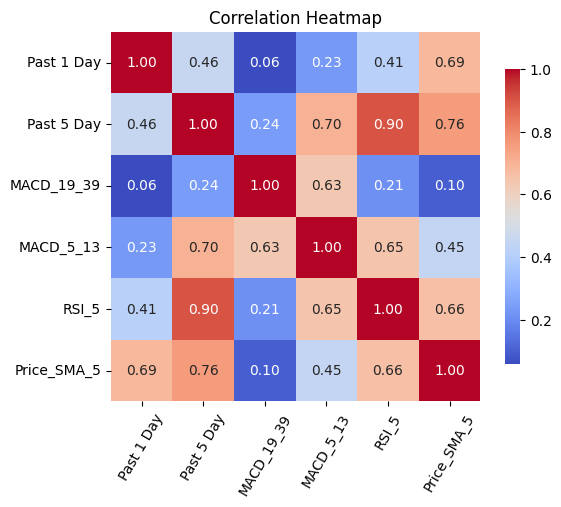

In [ ]:
correlation_matrix = X_train_reg_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

plt.title('Correlation Heatmap')
plt.xticks(rotation = 60)
# plt.yticks(rotation=45)
plt.show()

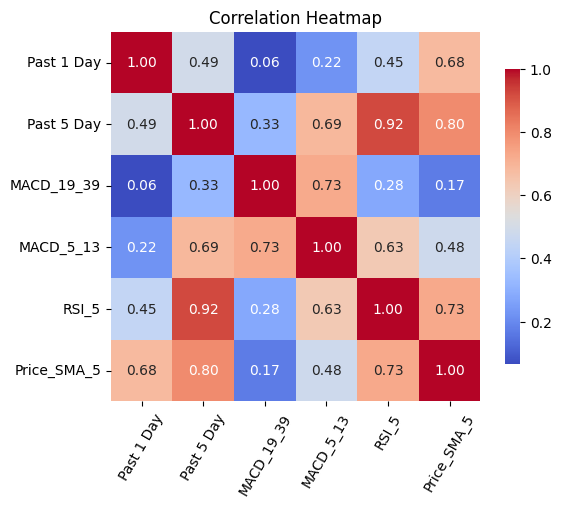

In [ ]:
correlation_matrix = X_test.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

plt.title('Correlation Heatmap')
plt.xticks(rotation = 60)
# plt.yticks(rotation=45)
plt.show()


In [ ]:
# Calculate VIF (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif_results = calculate_vif(X_test)
print("\nVariance Inflation Factors:")
print(vif_results)


Variance Inflation Factors:
      Variable       VIF
0   Past 1 Day  1.939116
1   Past 5 Day  4.468712
2   MACD_19_39  2.509767
3    MACD_5_13  4.127303
4        RSI_5  1.295713
5  Price_SMA_5  4.011594


### Check identical predictions

In [ ]:
# First, let's check predictions from MLP supervised model
print("MLP Supervised Model Predictions:")
raw_pred_mlp_sup = mlp_supervised.predict(X_test)
sign_mlp_sup = np.sign(raw_pred_mlp_sup - 0.5)

MLP Supervised Model Predictions:
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
unique_values, counts = np.unique(sign_mlp_sup, return_counts = True)
print(dict(zip(unique_values, counts)))

{1.0: 1200}


In [ ]:
# Next, check Lasso supervised model
print("\nLasso Supervised Model Predictions:")
raw_pred_lasso_sup = lasso_supervised.predict(X_test)
# print("First  raw predictions:", raw_pred_lasso_sup[: 15])
sign_lasso_sup = np.sign(raw_pred_lasso_sup - 0.5)
# print("Converted to signals:", sign_lasso_sup[: 15])


Lasso Supervised Model Predictions:
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
unique_values, counts = np.unique(sign_lasso_sup, return_counts = True)
print(dict(zip(unique_values, counts)))

{1.0: 1200}


In [ ]:
# Now check MLP with Sharpe loss
print("\nMLP Sharpe Loss Model Predictions:")
raw_pred_mlp_sharpe = mlp_sharpe.predict(X_test)
sign_mlp_sharpe = np.sign(raw_pred_mlp_sharpe)
# print("First 5 raw predictions:", raw_pred_mlp_sharpe[: 15])  # Should be between -1 and 1
# print("Converted to signals:", np.sign(raw_pred_mlp_sharpe)[: 15])


MLP Sharpe Loss Model Predictions:
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
unique_values, counts = np.unique(sign_mlp_sharpe, return_counts = True)
print(dict(zip(unique_values, counts)))

{-1.0: 85, 1.0: 1115}


In [ ]:
print("\nLasso Sharpe Loss Model Predictions:")
raw_pred_lasso_sharpe = lasso_sharpe.predict(X_test)
sign_lasso_sharpe = np.sign(raw_pred_lasso_sharpe)


Lasso Sharpe Loss Model Predictions:
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
unique_values, counts = np.unique(sign_lasso_sharpe, return_counts = True)
print(dict(zip(unique_values, counts)))

{1.0: 1200}


In [ ]:
# Save results
stats.to_csv("model_comparison_results.csv")

### calling once

Trial 50 Complete [00h 00m 10s]
val_loss: 5.205727577209473

Best val_loss So Far: 0.6807206869125366
Total elapsed time: 00h 06m 37s
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.8757 - val_loss: 0.8549
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.8082 - val_loss: 0.6867
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6870 - val_loss: 0.6998
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7113 - val_loss: 0.7289
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7377 - val_loss: 0.7334
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7374 - val_loss: 0.7166
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7166 - val_loss: 0.6947
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6956 - val_loss: 0.6833
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6832 - val_loss: 0.6877
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6887 - val_loss: 0.6955
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━

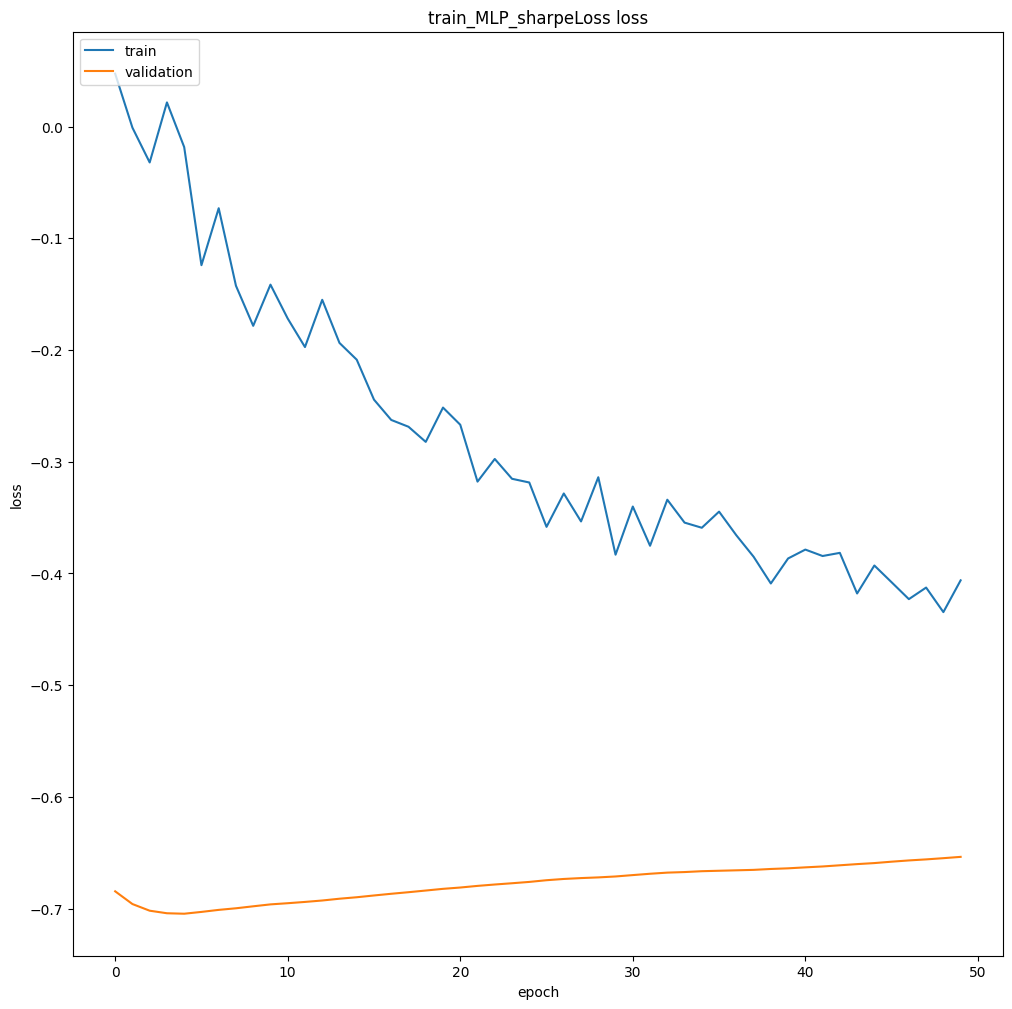

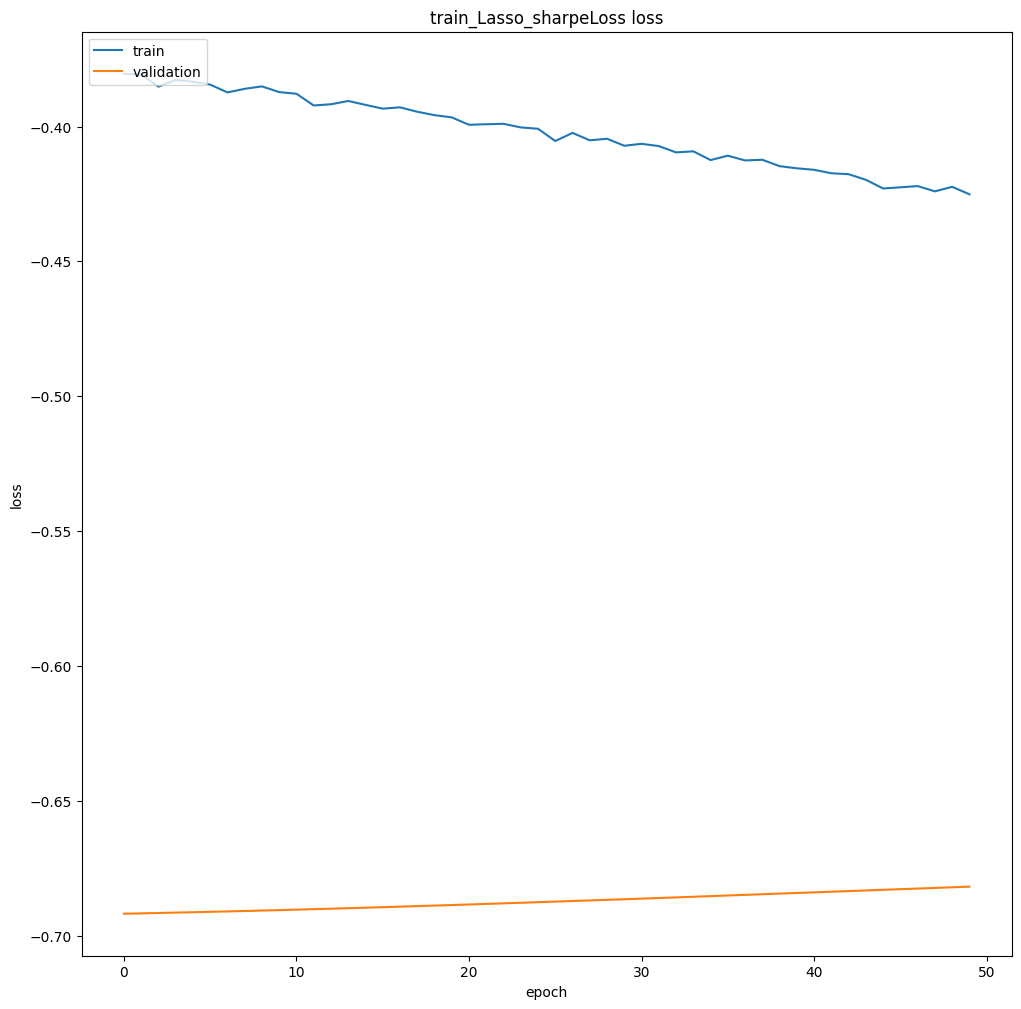

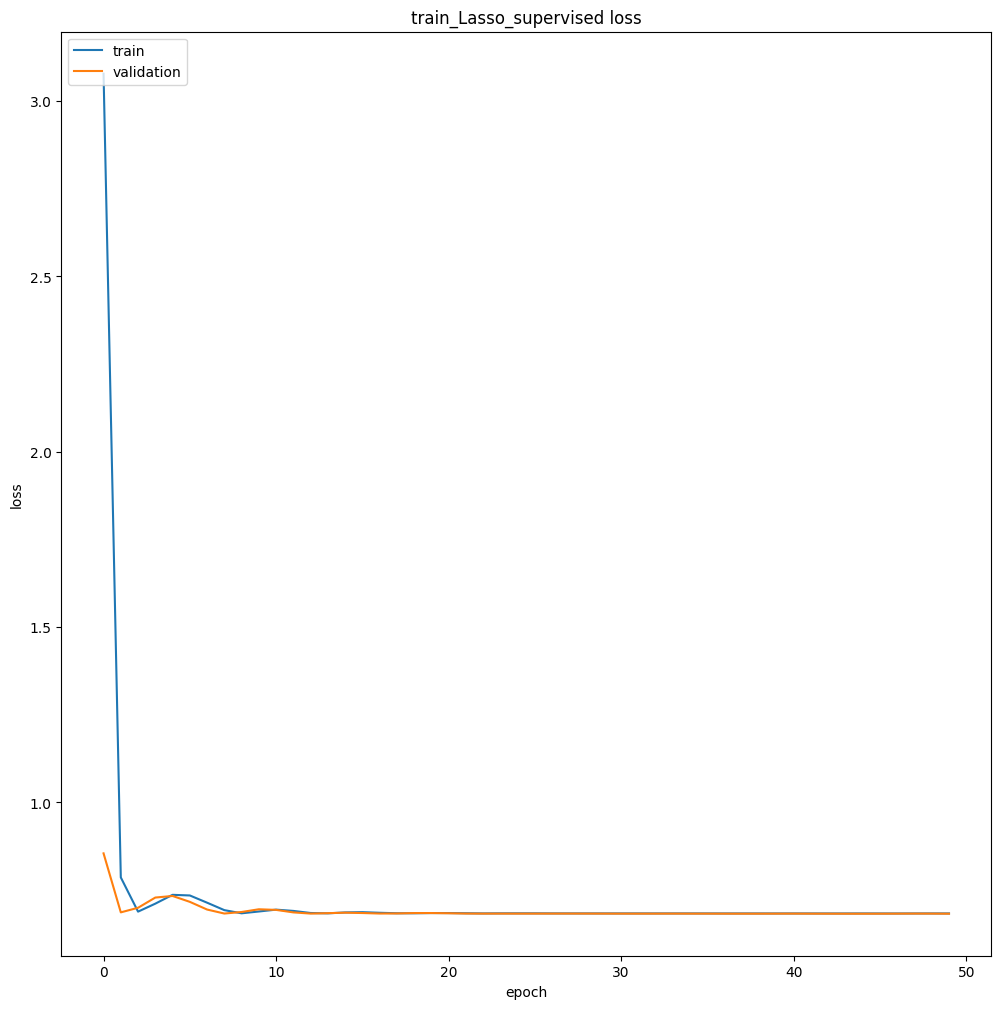

In [ ]:
start_time = '2018-12-31'
end_time = '2024-12-31'

# start_time = '2004-12-31'
# end_time = '2019-12-31'

k = 5
h = 10

data = EU_Stock_data(start_time = start_time, end_time = end_time)

X_supervised, y_supervised = feature_engineering(data,k,h,supervised = True)
X_sharpeloss, y_sharpeloss = feature_engineering(data,k,h,supervised = False)

test_data = data[data.index > datetime(pd.to_datetime(start_time).year + 5,12,31)]

model_name = ['train_MLP_sharpeLoss','train_Lasso_sharpeLoss', 'train_Lasso_supervised']

for model in model_name:
    func = globals()[model]
    if model == 'classic_TSMOM':

        signal = func(test_data,k,h)
        # signal.to_csv("signal_" + str(model) + ".csv")
        pnl = strategy_daily_return(backtest(test_data,signal,k,h)[0])

    elif model in ['train_decision_tree','train_xgboost','train_MLP_supervised','train_Lasso_supervised']:
        X_train = np.array(X_supervised[X_supervised.index <= datetime(pd.to_datetime(start_time).year + 4,12,31)], dtype=np.float64)
        y_train = np.array(y_supervised[y_supervised.index <= datetime(pd.to_datetime(start_time).year + 4,12,31)], dtype=np.float64)

        X_val = np.array(X_supervised[(X_supervised.index > datetime(pd.to_datetime(start_time).year + 4,12,31)) & (X_supervised.index <= datetime(pd.to_datetime(start_time).year + 5,12,31))], dtype=np.float64)
        y_val = np.array(y_supervised[(y_supervised.index > datetime(pd.to_datetime(start_time).year + 4,12,31)) & (y_supervised.index <= datetime(pd.to_datetime(start_time).year + 5,12,31))], dtype=np.float64)

        if model in ['train_MLP_supervised','train_Lasso_supervised']:
            temp_model, history = func(X_train,y_train,X_val,y_val,k,h)
            loss_history(history,str(model))
            del history
        else:
            temp_model = func(X_train,y_train,X_val,y_val,k,h)
        signal = test_model_TSMOM(test_data,temp_model,k,h)
        # signal.to_csv("signal_" + str(model) + ".csv")
        pnl = strategy_daily_return(backtest(test_data,signal,k,h)[0])

        del temp_model

    else:
        X_train = np.array(X_sharpeloss[X_sharpeloss.index <= datetime(pd.to_datetime(start_time).year + 4,12,31)], dtype=np.float64)
        y_train = np.array(y_sharpeloss[y_sharpeloss.index <= datetime(pd.to_datetime(start_time).year + 4,12,31)], dtype=np.float64)

        X_val = np.array(X_sharpeloss[(X_sharpeloss.index > datetime(pd.to_datetime(start_time).year + 4,12,31)) & (X_sharpeloss.index <= datetime(pd.to_datetime(start_time).year + 5,12,31))], dtype=np.float64)
        y_val = np.array(y_sharpeloss[(y_sharpeloss.index > datetime(pd.to_datetime(start_time).year + 4,12,31)) & (y_sharpeloss.index <= datetime(pd.to_datetime(start_time).year + 5,12,31))], dtype=np.float64)

        temp_model,history = func(X_train,y_train,X_val,y_val,k,h)
        loss_history(history,str(model))
        del history
        signal = test_model_TSMOM(test_data,temp_model,k,h)
        # signal_1.to_csv("signal_" + str(model) + ".csv")
        pnl = strategy_daily_return(backtest(test_data,signal,k,h)[0])

        del temp_model

    try:
        temp = pnl.to_list()
        temp.insert(0,model)
        stats.loc[len(stats.index)] = temp
    except:
        index = pnl.index.to_list()
        index.insert(0,'Model')
        stats = pd.DataFrame(columns = index)
        temp = pnl.to_list()
        temp.insert(0,model)
        stats.loc[len(stats.index)] = temp


stats.to_csv("result_5Y_sharpe_relu_unsign_vol.csv")

## Plot

In [ ]:
def to_string(df):
  for col in df.columns:
      if col != 'Model':  # Skip the Model column
          # Convert the column header (dates) to the desired format
          date_str = pd.to_datetime(col).strftime('%Y-%m-%d %H:%M:%S')
          # Rename the column with the formatted date
          df = df.rename(columns={col: date_str})
  return df


In [ ]:
start_time = '2024-01-01'
end_time = '2024-12-31'

In [ ]:
## Index
def EU_Index_data():

    stock_list =['^STOXX50E']
    futures = pd.DataFrame(columns= stock_list)

    time_index = list(yf.Ticker(stock_list[0]).history(period = 'max',start = start_time, end = end_time).index)
    flag = 0

    for symbol in stock_list:
        df = yf.Ticker(symbol).history(period = 'max', start = start_time, end = end_time)
        df = pd.DataFrame(df['Close'])
        i = 0
        daily_return = []
        for k in df['Close']:
            if i != 0:
                daily_return.append(float((k-i)/i))
            else:
                daily_return.append(float(0))
            i = k
        if time_index != list(df.index): flag +=1
        try:
            futures[symbol] = daily_return
        except:
            print(symbol)
            print(len(daily_return)) # Check differnet time index
            while len(daily_return) < len(futures):
                daily_return.insert(0,np.nan)
            futures[symbol] = daily_return

    futures.index = time_index
    futures = futures.iloc[1:, :]


    # print(flag) # Check differnet time index

    futures['Date'] = pd.to_datetime(futures.index, format='%Y-%m-%d')
    futures.set_index('Date', inplace=True)

    return futures

In [ ]:
EU_50 = EU_Index_data().transpose()

In [ ]:
def cummulative_returning(data):
    return  (data.iloc[:,2:] + 1).cumprod(axis = 1).iloc[:,-1]

def annualise_return(data):
    return (1 + cummulative_returning(data))**(252/ (data.shape[1] - 2)) - 1

def sharpe_ratio(df):
    result = []
    for x,v in enumerate(df.T):
        result.append(df.iloc[x][3 + int(df.iloc[x]['k']):].mean() / df.iloc[x][2 + int(df.iloc[x]['k']):].std(ddof = 1)* np.sqrt(252))
    return result

def maximum_drawdown(data):
    cumulative = (data.iloc[:,2:] + 1).cumprod(axis = 1)
    max_return = cumulative.cummax(axis = 1)
    return cumulative.sub(max_return).div(max_return).min(axis = 1)

def calmar_ratio(data):
    return annualise_return(data)/ -maximum_drawdown(data)

def sortino_ratio(data):
    k = data.iloc[:,2:] > 0
    x= data.iloc[:,2:]
    x[k] = 0.0
    x = np.square(x)
    x = np.nanmean(x, axis=1)
    x = np.sqrt(x) * np.sqrt(252)
    y = np.nanmean(data.iloc[:,2:], axis=1)
    return y/x * np.sqrt(252)

In [ ]:
stats_test

,Model,2024-01-02 00:00:00,2024-01-03 00:00:00,2024-01-04 00:00:00,2024-01-05 00:00:00,2024-01-08 00:00:00,2024-01-09 00:00:00,2024-01-10 00:00:00,2024-01-11 00:00:00,2024-01-12 00:00:00,...,2024-12-13 00:00:00,2024-12-16 00:00:00,2024-12-17 00:00:00,2024-12-18 00:00:00,2024-12-19 00:00:00,2024-12-20 00:00:00,2024-12-23 00:00:00,2024-12-24 00:00:00,2024-12-27 00:00:00,2024-12-30 00:00:00
0,"classic_tsmom_with target ( k = 5, h = 10)",0.0,0.0,0.0,0.0,0.0,0.0,0.001201,0.001491,-0.001034,...,0.000996,-0.000713,-0.001773,-0.000582,0.000360,-0.001784,0.000202,-0.001647,0.001331,-0.000151
1,"MLP SharpeLoss with direct (k = 5, h = 10)",0.0,0.0,0.0,0.0,0.0,0.0,0.000073,0.006666,-0.009540,...,-0.001315,0.002585,0.004298,-0.000191,0.010769,0.003024,0.001273,-0.000482,-0.008351,0.002921
2,"Lasso_SharpeLoss with direct (k = 5, h = 10)",0.0,0.0,0.0,0.0,0.0,0.0,-0.000252,-0.004014,0.004948,...,0.000579,-0.000606,-0.001637,0.000256,-0.004222,-0.001456,-0.000505,-0.000132,0.003043,-0.000705
3,"MLP SharpeLoss with direct (k = 5, h = 10)",0.0,0.0,0.0,0.0,0.0,0.0,-0.001050,-0.007537,0.009878,...,0.001525,-0.004637,-0.004217,0.000008,-0.011281,-0.002933,-0.001921,0.000482,0.009336,-0.002554


In [ ]:
stats_test.drop([1], inplace = True)

In [ ]:
stats_test.to_csv('sharpe loss_mlp_lasso_direct.csv')

In [ ]:
df = stats_test

In [ ]:
# stats_test.to_csv('tsmom_no target vs target vs index.csv')

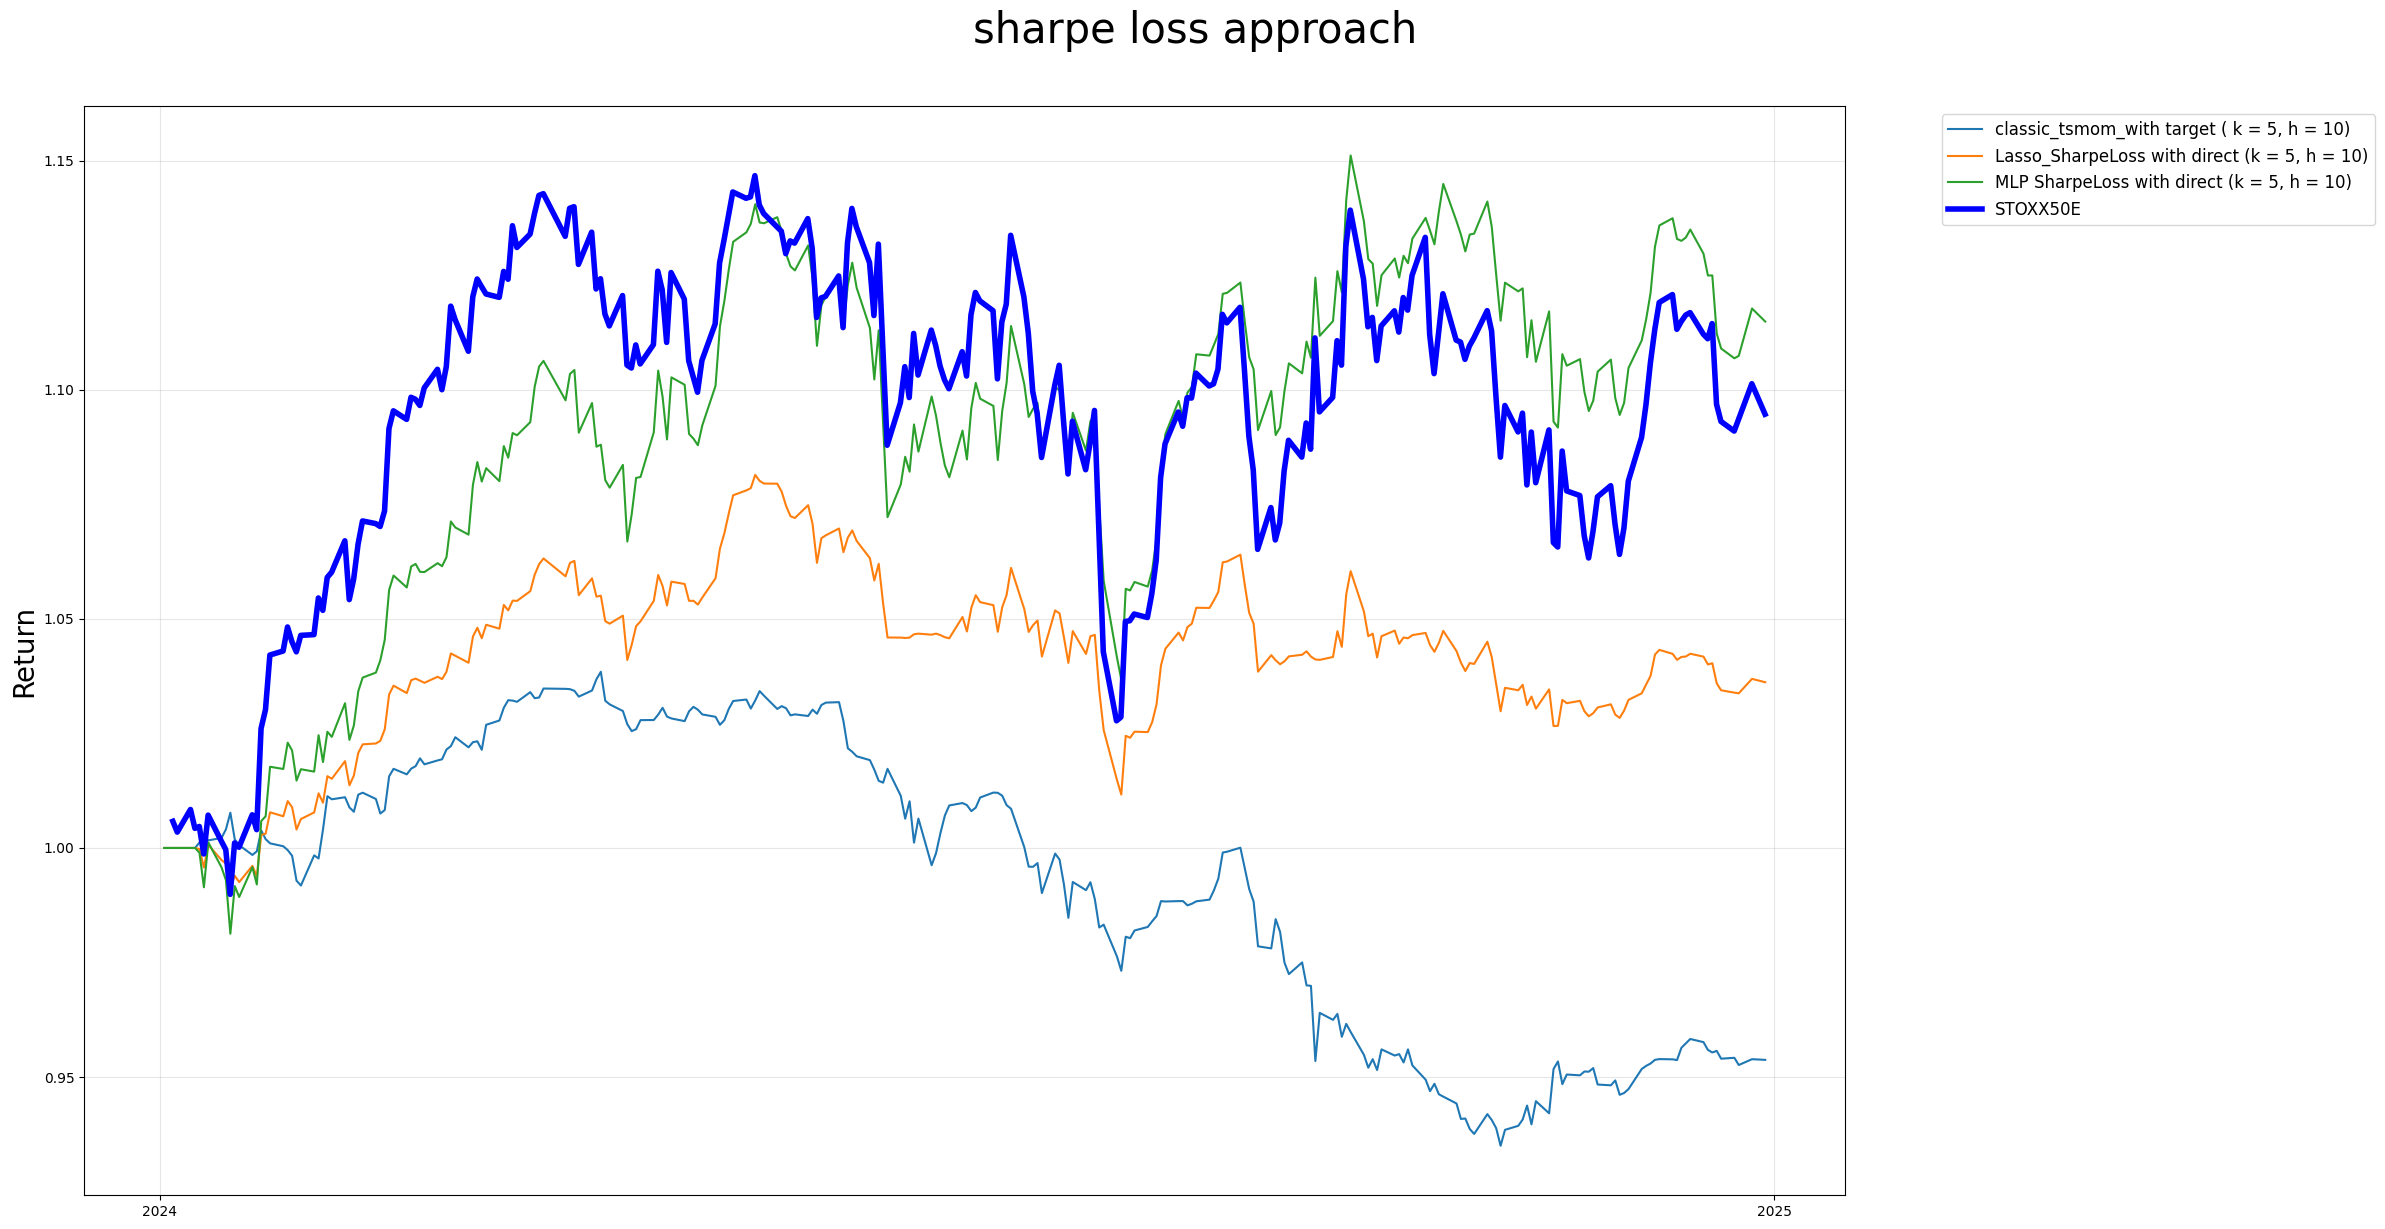

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax1 = plt.subplots( figsize=(24, 12))

# Top subplot - original scale
benchmark = (EU_50+1).cumprod(axis=1).loc['^STOXX50E']
df.columns = pd.to_datetime(df.columns, format='%Y-%m-%d %H:%M:%S', errors='ignore')
cummulative_return = ((df.iloc[:, 1:] + 1).cumprod(axis=1))
cummulative_return = cummulative_return.reset_index(drop=True)
last_date = cummulative_return.columns[-1]

# Plot all lines in top subplot
for x in range(len(df)):
    try:
        ax1.plot(cummulative_return.loc[x], label=f"{df.iloc[x]['Model']}")
    except Exception as e:
        print(f"Error plotting line {x}: {e}")

ax1.plot(benchmark, color='Blue', linewidth=4, label='STOXX50E')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
ax1.set_ylabel("Return", fontsize=20)
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.grid(True, alpha=0.3)
# ax1.set_title('Full Scale View', fontsize=20)

# Bottom subplot - zoomed in on the lower returns
# Filter out the high-performing strategies to focus on the ones near the benchmark
threshold = benchmark.iloc[-1] * 3  # Adjust this multiplier as needed
lower_performing = cummulative_return[cummulative_return.iloc[:,-1] < threshold]

# for x in range(len(lower_performing)):
#     try:
#         ax2.plot(lower_performing.loc[x],
#                  label=f"{df.iloc[lower_performing.index[x]]['Model']}")
#     except Exception as e:
#         print(f"Error plotting line {x}: {e}")

# ax2.plot(benchmark, color='Blue', linewidth=4, label='STOXX50E')
# ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
# ax2.set_xlabel("Time", fontsize=20)
# ax2.set_ylabel("Return", fontsize=20)
# ax2.xaxis.set_major_locator(mdates.YearLocator())
# ax2.grid(True, alpha=0.3)
# ax2.set_title('Zoomed View of Lower-Performing Strategiesr', fontsize=20)

# # Set y-axis limits for bottom subplot to focus on the area of interest
# ax2.set_ylim(0.8, 2.0)  # Adjust these values based on your data

plt.suptitle('sharpe loss approach', fontsize=30, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
vstats_test.to_csv('regression model k = 5 h = 3.csv')

In [ ]:
stats_test_rerun.to_csv('regression model k = 5 h = 3 rerun.csv')

### Train theo Rolling Window